# Premier League Player Role Discovery - Phase 4: Explainability

This notebook builds on the PCA and clustering analysis from Phase 3 to:
1. Interpret the 3 clusters identified through K-Means
2. Apply explainability techniques to understand feature importance
3. Identify representative players for each cluster
4. Assign meaningful role names based on statistical evidence

## Approach

1. Cluster Summary Statistics - Analyze key metrics per cluster
2. Feature Importance Analysis - Identify distinctive features using z-scores
3. SHAP Explainability - Train surrogate model and compute feature importance
4. Representative Players - Find exemplars of each cluster
5. Role Naming - Synthesize insights into meaningful football role labels

The final outputs will feed directly into the Streamlit application development.


## Setup and Data Loading


In [1]:
## Setup and Data Loading

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import pickle
import warnings
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.inspection import permutation_importance
import shap
from scipy import stats

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=1.2)

# Define consistent colors for clusters
CLUSTER_COLORS = {
    0: "#1f77b4",  # blue - defensive specialists       
    1: "#ff7f0e",  # orange - creative playmakers
    2: "#2ca02c",  # green - clinical finishers
}

# Suppress warnings
warnings.filterwarnings('ignore')

# Create directories if they don't exist
os.makedirs("../models", exist_ok=True)
os.makedirs("../data/processed", exist_ok=True)

print("Setup complete.")


Setup complete.


## Data Loading

load the four key datasets from Phase 3:
1. `player_clusters.csv` - Player metadata and cluster assignments
2. `player_pca_projection.csv` - PCA components for each player
3. `player_umap_2d.csv` - 2D UMAP coordinates for visualization
4. `player_stats_engineered.csv` - Full feature set with engineered features


In [2]:
## Load Data Files

# Load the four key datasets from Phase 3
try:
    # Player clusters with metadata
    player_clusters = pd.read_csv("../data/processed/player_clusters.csv")
    print(f"Loaded player_clusters.csv: {player_clusters.shape[0]} players with cluster assignments")
    
    # Debug: Check columns in player_clusters
    print("Columns in player_clusters:", player_clusters.columns.tolist())
    print("\nFirst 5 rows of player_clusters:")
    print(player_clusters.head())
    
    # PCA projections
    pca_projection = pd.read_csv("../data/processed/player_pca_projection.csv")
    print(f"Loaded player_pca_projection.csv: {pca_projection.shape[1]-1} PCA components")
    
    # UMAP coordinates for visualization
    umap_coords = pd.read_csv("../data/processed/player_umap_2d.csv")
    print(f"Loaded player_umap_2d.csv: {umap_coords.shape[0]} players with 2D coordinates")
    
    # Original engineered features
    player_features = pd.read_csv("../data/processed/player_stats_engineered.csv")
    print(f"Loaded player_stats_engineered.csv: {player_features.shape[1]} features")
    
except FileNotFoundError as e:
    print(f"Error: {e}")
    print("Please ensure Phase 3 has been completed and all output files are available.")


Loaded player_clusters.csv: 563 players with cluster assignments
Columns in player_clusters: ['player', 'cluster', 'team', 'position']

First 5 rows of player_clusters:
               player  cluster             team position
0     Aaron Cresswell        1         West Ham       DF
1      Aaron Ramsdale        0      Southampton       GK
2   Aaron Wan-Bissaka        0         West Ham       DF
3  Abdoulaye Doucouré        0          Everton       MF
4  Abdukodir Khusanov        1  Manchester City       DF
Loaded player_pca_projection.csv: 31 PCA components
Loaded player_umap_2d.csv: 563 players with 2D coordinates
Loaded player_stats_engineered.csv: 266 features


## Creating Master DataFrame

We'll merge all datasets into a single master dataframe for analysis, ensuring all player data, features, and cluster assignments are aligned.


In [3]:
## Create Master DataFrame

# Merge all datasets into a single master dataframe
try:
    # First, check columns in player_clusters to confirm 'cluster' exists
    print("Columns in player_clusters:", player_clusters.columns.tolist())
    print("\nFirst 5 rows of player_clusters:")
    print(player_clusters[['player', 'cluster']].head())
    
    # Start with player clusters (contains player metadata and cluster assignments)
    master_df = player_clusters.copy()
    
    # Add PCA components
    master_df = master_df.merge(pca_projection, on="player", how="left")
    
    # Add UMAP coordinates
    master_df = master_df.merge(umap_coords, on="player", how="left")
    
    # Add engineered features
    master_df = master_df.merge(player_features, on="player", how="left")
    
    # Check for missing values after merge
    missing_count = master_df.isnull().sum().sum()
    if missing_count > 0:
        print(f"Warning: {missing_count} missing values detected after merging datasets")
    else:
        print("All datasets merged successfully with no missing values")
    
    # Verify the cluster column still exists after merges
    print("\nColumns in master_df after merging:", master_df.columns.tolist())
    
    # Fix the cluster column issue properly
    # This is a critical column so we need to ensure it's correct
    print("\n=== Fixing Cluster Column ===")
    
    # First check if we have duplicate cluster columns
    cluster_cols = [col for col in master_df.columns if 'cluster' in col.lower()]
    print(f"Found {len(cluster_cols)} cluster-related columns: {cluster_cols}")
    
    # If we have both cluster_x and cluster_y, check which one is more complete
    if 'cluster_x' in master_df.columns and 'cluster_y' in master_df.columns:
        x_missing = master_df['cluster_x'].isnull().sum()
        y_missing = master_df['cluster_y'].isnull().sum()
        print(f"Missing values: cluster_x: {x_missing}, cluster_y: {y_missing}")
        
        if x_missing <= y_missing:
            print("Using cluster_x as primary cluster column")
            master_df['cluster'] = master_df['cluster_x']
        else:
            print("Using cluster_y as primary cluster column")
            master_df['cluster'] = master_df['cluster_y']
    
    # If we still don't have a 'cluster' column, re-add from original data
    if 'cluster' not in master_df.columns:
        print("Creating new cluster column from player_clusters")
        # Verify player_clusters has the right data
        print(f"player_clusters shape: {player_clusters.shape}")
        print(f"player_clusters cluster distribution:\n{player_clusters['cluster'].value_counts()}")
        
        # Create a new merge on player column to ensure we have cluster data
        master_df = master_df.merge(player_clusters[['player', 'cluster']], on='player', how='left')
    
    # Verify the cluster column is present and has the expected distribution
    print("\nVerifying final cluster column:")
    if 'cluster' in master_df.columns:
        cluster_counts = master_df['cluster'].value_counts().sort_index()
        print(f"Cluster distribution:\n{cluster_counts}")
        
        # Check for missing values
        missing = master_df['cluster'].isnull().sum()
        if missing > 0:
            print(f"WARNING: {missing} missing values in cluster column")
            # Fill missing values with most common cluster
            most_common = master_df['cluster'].mode()[0]
            master_df['cluster'] = master_df['cluster'].fillna(most_common)
            print(f"Filled missing values with most common cluster: {most_common}")
        else:
            print("No missing values in cluster column - perfect!")
    else:
        print("ERROR: Failed to create cluster column!")
    
    # Clean up the dataframe
    print("\n=== Data Quality Analysis ===")
    
    # Remove error columns
    error_cols = [col for col in master_df.columns if 'error' in col.lower()]
    if error_cols:
        print(f"Removing error columns: {error_cols}")
        master_df = master_df.drop(columns=error_cols)
    
    # Handle duplicate columns by keeping the most complete ones
    duplicate_patterns = ['cluster_x', 'cluster_y', 'team_x', 'team_y', 'position_x', 'position_y']
    for pattern in duplicate_patterns:
        if pattern in master_df.columns:
            # Keep the version with fewer missing values
            base_name = pattern.split('_')[0]
            if f"{base_name}_x" in master_df.columns and f"{base_name}_y" in master_df.columns:
                x_missing = master_df[f"{base_name}_x"].isnull().sum()
                y_missing = master_df[f"{base_name}_y"].isnull().sum()
                
                if x_missing <= y_missing:
                    master_df[base_name] = master_df[f"{base_name}_x"]
                    master_df = master_df.drop(columns=[f"{base_name}_x", f"{base_name}_y"])
                else:
                    master_df[base_name] = master_df[f"{base_name}_y"]
                    master_df = master_df.drop(columns=[f"{base_name}_x", f"{base_name}_y"])
                print(f"Resolved duplicate {base_name} columns")
    
    # Remove columns that are mostly metadata/identifiers
    metadata_cols = [col for col in master_df.columns if any(x in col.lower() for x in ['row_id', 'rk', 'nation', 'born'])]
    if metadata_cols:
        print(f"Removing metadata columns: {len(metadata_cols)} columns")
        master_df = master_df.drop(columns=metadata_cols)
    
    # Fix composite indices - they seem to be problematic
    print("\n=== Fixing Composite Indices ===")
    composite_indices = ['PI', 'CCI', 'DA', 'FE']
    
    # Check if we need to recalculate these indices
    need_recalculation = False
    for idx in composite_indices:
        if idx in master_df.columns:
            # Check for extreme values
            max_val = master_df[idx].max()
            min_val = master_df[idx].min()
            if abs(max_val) > 1e6 or abs(min_val) > 1e6 or np.isnan(master_df[idx]).any():
                print(f"Warning: {idx} has extreme values (max: {max_val:.2e}, min: {min_val:.2e})")
                need_recalculation = True
    
    # If indices have extreme values, recalculate them from scratch
    if need_recalculation:
        print("Recalculating composite indices from scratch...")
        
        # Define the indices based on football domain knowledge
        # PI: Progression Index - ability to move the ball forward
        if all(col in master_df.columns for col in ['prgp_per90', 'prgc_per90']):
            master_df['PI'] = master_df['prgp_per90'] + master_df['prgc_per90']
            print("Recalculated PI from progression metrics")
        
        # CCI: Chance Creation Index - ability to create scoring opportunities
        if all(col in master_df.columns for col in ['kp_per90', 'xag_per90', 'sca_per90']):
            master_df['CCI'] = master_df['kp_per90'] + master_df['xag_per90'] + 0.1 * master_df['sca_per90']
            print("Recalculated CCI from chance creation metrics")
        
        # DA: Defensive Action - ability to win back possession
        if all(col in master_df.columns for col in ['tkl_per90', 'int_per90', 'blocks_per90']):
            master_df['DA'] = master_df['tkl_per90'] + master_df['int_per90'] + master_df['blocks_per90']
            print("Recalculated DA from defensive metrics")
        
        # FE: Finishing Efficiency - ability to score goals
        if all(col in master_df.columns for col in ['gls_per90', 'xg_per90']):
            # Avoid division by zero
            master_df['FE'] = master_df['gls_per90'] / master_df['xg_per90'].replace(0, 0.01)
            # Cap at reasonable values
            master_df['FE'] = master_df['FE'].clip(0, 3)
            print("Recalculated FE from finishing metrics")
    
    # Standardize the indices (z-score normalization)
    print("\nStandardizing composite indices...")
    for idx in composite_indices:
        if idx in master_df.columns:
            # Replace any remaining infinities or NaNs
            master_df[idx] = master_df[idx].replace([np.inf, -np.inf], np.nan)
            master_df[idx] = master_df[idx].fillna(master_df[idx].median())
            
            # Z-score normalization
            master_df[idx] = (master_df[idx] - master_df[idx].mean()) / master_df[idx].std()
            
            # Report the new range
            print(f"{idx} range after standardization: {master_df[idx].min():.2f} to {master_df[idx].max():.2f}")
    
    # Display the final shape of the master dataframe
    print(f"\nFinal master dataframe shape: {master_df.shape[0]} rows × {master_df.shape[1]} columns")
    print(f"Missing values: {master_df.isnull().sum().sum()}")
    
    # Preview the dataframe
    master_df.head()
    
except Exception as e:
    print(f"Error creating master dataframe: {e}")


Columns in player_clusters: ['player', 'cluster', 'team', 'position']

First 5 rows of player_clusters:
               player  cluster
0     Aaron Cresswell        1
1      Aaron Ramsdale        0
2   Aaron Wan-Bissaka        0
3  Abdoulaye Doucouré        0
4  Abdukodir Khusanov        1

Columns in master_df after merging: ['player', 'cluster_x', 'team_x', 'position_x', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'PC16', 'PC17', 'PC18', 'PC19', 'PC20', 'PC21', 'PC22', 'PC23', 'PC24', 'PC25', 'PC26', 'PC27', 'PC28', 'PC29', 'PC30', 'PC31', 'x', 'y', 'cluster_y', 'team_y', 'position_y', 'row_id', 'rk', 'nation', 'position', 'team', 'age', 'born', 'mp', 'starts', 'minutes', '90s', 'gls', 'ast', 'gplusa', 'g_pk', 'pk', 'pkatt', 'crdy', 'crdr', 'xg', 'npxg', 'xag', 'npxgplusxag', 'prgc', 'prgp', 'prgr', 'gls1', 'ast1', 'gplusa1', 'g_pk1', 'gplusa_pk', 'xg1', 'xag1', 'xgplusxag', 'npxg1', 'npxgplusxag1', 'row_id_misc', 'rk_

## 1. Cluster Summary Statistics

In this section, analyze the basic distribution of players across clusters and visualize the results.


Cluster Distribution:


,Count,Percentage (%)
cluster,,
0,166,29.5
1,294,52.2
2,103,18.3


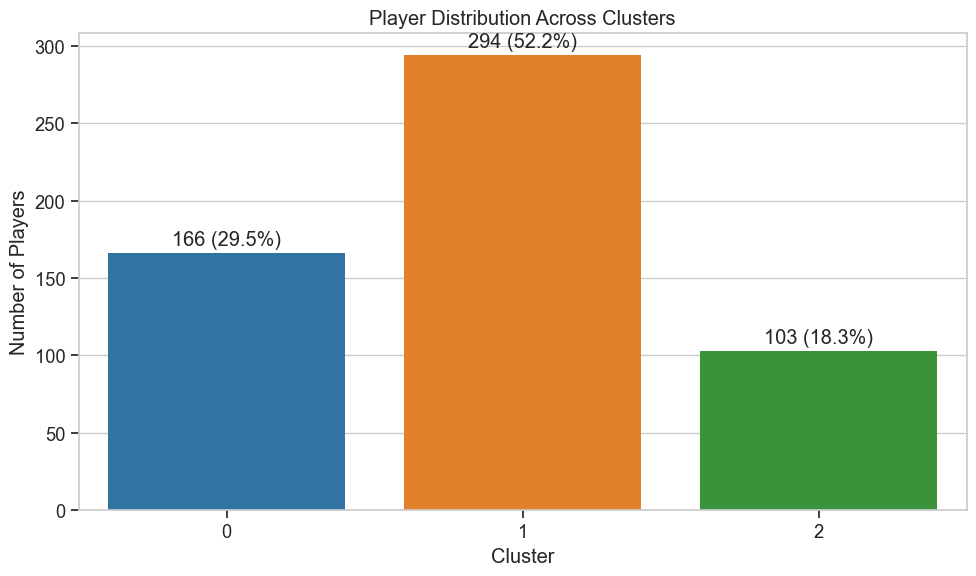

In [4]:
## 1. Cluster Summary Statistics

# Basic cluster demographics
cluster_counts = master_df['cluster'].value_counts().sort_index()
cluster_percentages = cluster_counts / cluster_counts.sum() * 100

# Create summary table
cluster_summary = pd.DataFrame({
    'Count': cluster_counts,
    'Percentage (%)': cluster_percentages.round(1)
})

print("Cluster Distribution:")
display(cluster_summary)

# Plot cluster distribution
plt.figure(figsize=(10, 6))
# Convert cluster index to integers for the color mapping
color_map = {str(k): v for k, v in CLUSTER_COLORS.items()}
ax = sns.barplot(x=cluster_summary.index, y='Count', data=cluster_summary, palette=color_map)
for i, count in enumerate(cluster_summary['Count']):
    ax.text(i, count + 5, f"{count} ({cluster_summary['Percentage (%)'][i]}%)", ha='center')
plt.title('Player Distribution Across Clusters')
plt.xlabel('Cluster')
plt.ylabel('Number of Players')
plt.tight_layout()
plt.show()


### 1.1 Composite Indices Analysis

We'll analyze the composite indices (PI, CCI, DA, FE) across clusters to understand their distribution and differences.


Found 4 composite indices: ['PI', 'CCI', 'DA', 'FE']

Composite Indices Summary Statistics by Cluster:


PI                           CCI                            DA  \
             mean    median       std      mean    median       std      mean   
cluster                                                                         
0        0.063836  0.053286  0.857415 -0.177408 -0.321825  0.731728  0.346365   
1       -0.216735 -0.200958  1.060120 -0.226276 -0.580363  1.019703 -0.052455   
2        0.515761  0.488037  0.825592  0.931796  0.912148  0.762402 -0.408494   

                                   FE                      
           median       std      mean    median       std  
cluster                                                    
0        0.475045  0.844707  0.202371  0.168211  1.019105  
1       -0.026848  1.119769 -0.336807 -0.760620  0.956019  
2       -0.475539  0.618101  0.635220  0.503622  0.635015


Creating radar chart for 3 clusters
PI range: -1.68 to 2.65
CCI range: -1.17 to 2.27
DA range: -1.72 to 2.78
FE range: -0.76 to 3.14
Cluster 0: 166 players
Cluster 0 means: [ 0.06383626 -0.17740791  0.34636472  0.20237127]
Cluster 1: 294 players
Cluster 1 means: [-0.21673525 -0.22627642 -0.05245462 -0.33680714]
Cluster 2: 103 players
Cluster 2 means: [ 0.51576063  0.93179591 -0.40849401  0.63522007]


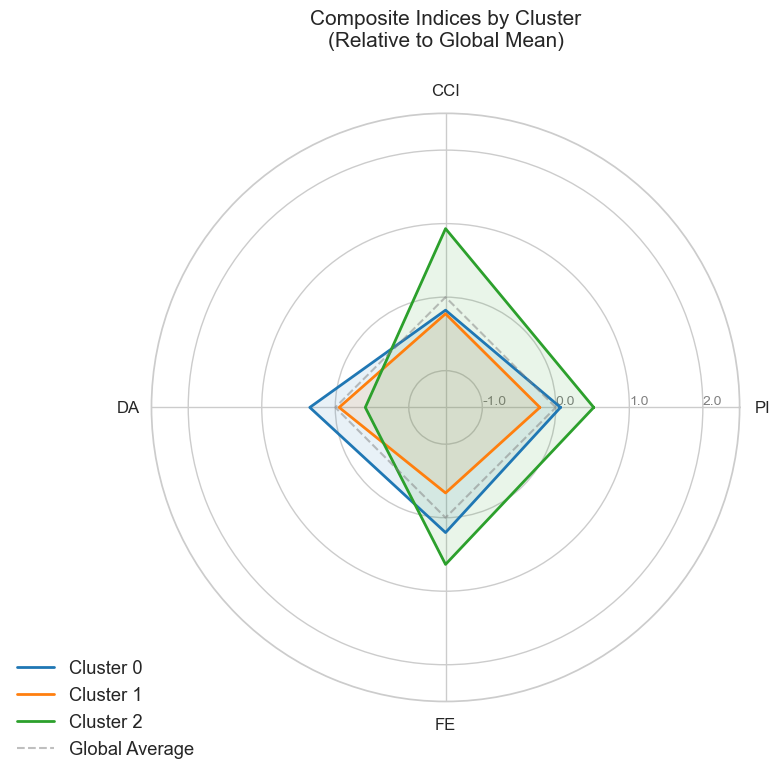

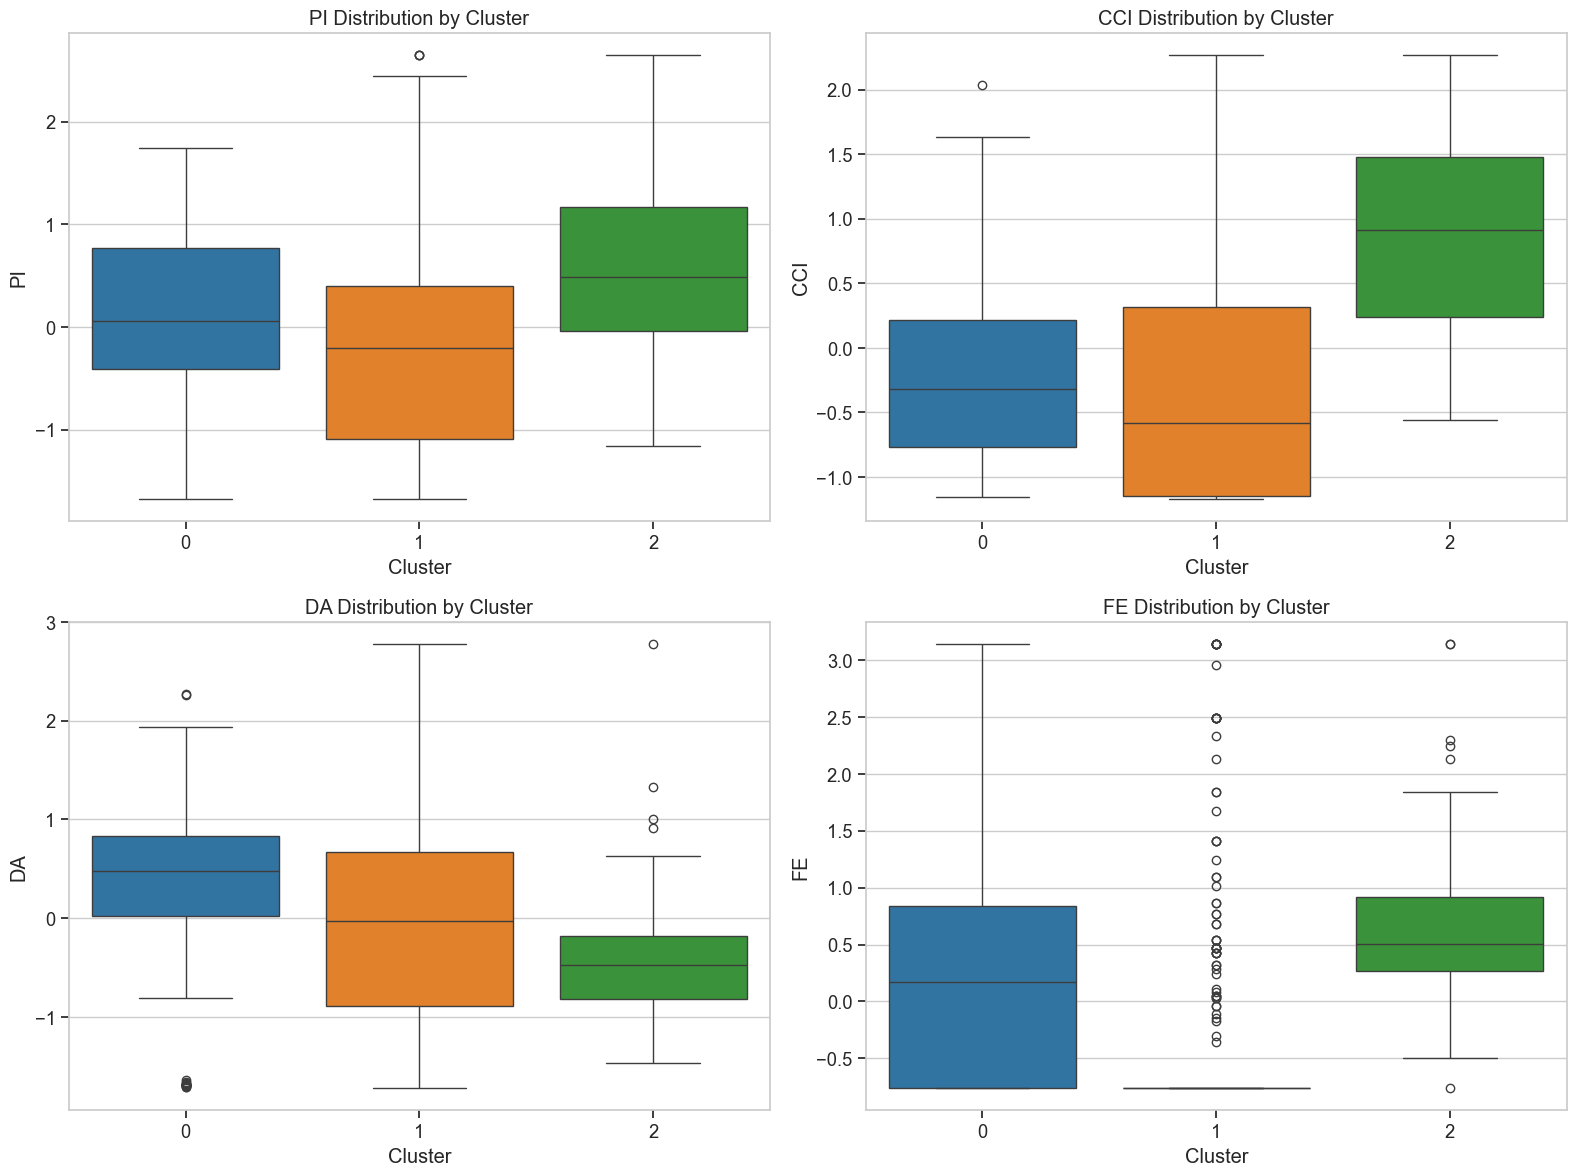

In [5]:
### Composite Indices Analysis

# Identify the composite indices from planning documentation
composite_indices = ['PI', 'CCI', 'DA', 'FE']

# Check if these indices exist in our dataset
available_indices = [idx for idx in composite_indices if idx in master_df.columns]

if len(available_indices) == 0:
    print("Warning: No composite indices found in the dataset")
    # Try to find them with different naming conventions
    possible_indices = [col for col in master_df.columns if any(idx.lower() in col.lower() for idx in composite_indices)]
    if possible_indices:
        print(f"Possible composite indices found: {possible_indices}")
        available_indices = possible_indices
else:
    print(f"Found {len(available_indices)} composite indices: {available_indices}")

# Calculate summary statistics for available composite indices by cluster
if available_indices:
    # Group by cluster and calculate mean, median, std for each index
    composite_stats = master_df.groupby('cluster')[available_indices].agg(['mean', 'median', 'std'])
    
    # Display summary statistics
    print("\nComposite Indices Summary Statistics by Cluster:")
    display(composite_stats)
    
    # Create radar chart for composite indices
    def radar_chart(df, indices, title):
        # Set up the figure
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, polar=True)
        
        # Number of variables
        N = len(indices)
        
        # Compute angle for each axis
        angles = [n / float(N) * 2 * np.pi for n in range(N)]
        angles += angles[:1]  # Close the loop
        
        # Draw one axis per variable and add labels
        plt.xticks(angles[:-1], indices, size=12)
        
        # Draw ylabels - for z-scores, use different scale
        ax.set_rlabel_position(0)
        plt.yticks([-1, 0, 1, 2], ["-1.0", "0.0", "1.0", "2.0"], color="grey", size=10)
        plt.ylim(-1.5, 2.5)
        
        # Plot data
        print(f"\nCreating radar chart for {len(df['cluster'].unique())} clusters")
        
        # First check if all indices exist in the dataframe
        missing_indices = [idx for idx in indices if idx not in df.columns]
        if missing_indices:
            print(f"Warning: Missing indices: {missing_indices}")
            # Only use available indices
            indices = [idx for idx in indices if idx in df.columns]
            print(f"Using available indices: {indices}")
            
            if not indices:
                print("No indices available for radar chart!")
                return fig
        
        # Check if indices have reasonable values
        for idx in indices:
            min_val = df[idx].min()
            max_val = df[idx].max()
            print(f"{idx} range: {min_val:.2f} to {max_val:.2f}")
            
            if np.isnan(min_val) or np.isnan(max_val) or np.isinf(min_val) or np.isinf(max_val):
                print(f"Warning: {idx} has invalid values!")
        
        for cluster in sorted(df['cluster'].unique()):
            # Ensure cluster is an integer for color mapping
            cluster_int = int(cluster) if isinstance(cluster, str) else cluster
            
            # Get data for this cluster
            cluster_data = df[df['cluster'] == cluster]
            print(f"Cluster {cluster}: {len(cluster_data)} players")
            
            # Calculate z-score means for this cluster
            # Since we've already standardized the indices, we can just use the mean directly
            cluster_means = cluster_data[indices].mean().values
            
            print(f"Cluster {cluster} means: {cluster_means}")
            
            # Close the loop
            values = np.concatenate((cluster_means, [cluster_means[0]]))
            
            # Plot values
            ax.plot(angles, values, linewidth=2, linestyle='solid', label=f"Cluster {cluster}", color=CLUSTER_COLORS[cluster_int])
            ax.fill(angles, values, alpha=0.1, color=CLUSTER_COLORS[cluster_int])
        
        # Add reference line at 0.0 (global average for z-scores)
        ax.plot(angles, [0.0] * len(angles), color='gray', linestyle='--', alpha=0.5, label='Global Average')
        
        # Add legend
        plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
        plt.title(title, size=15, y=1.1)
        
        return fig
    
    # Create radar chart
    radar_fig = radar_chart(master_df, available_indices, 'Composite Indices by Cluster\n(Relative to Global Mean)')
    plt.tight_layout()
    plt.show()
    
    # Create boxplots for each composite index
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()
    
    # Convert cluster index to strings for the color mapping
    color_map = {str(k): v for k, v in CLUSTER_COLORS.items()}
    
    for i, idx in enumerate(available_indices):
        if i < len(axes):
            sns.boxplot(x='cluster', y=idx, data=master_df, palette=color_map, ax=axes[i])
            axes[i].set_title(f'{idx} Distribution by Cluster')
            axes[i].set_xlabel('Cluster')
            axes[i].set_ylabel(idx)
    
    plt.tight_layout()
    plt.show()
else:
    print("No composite indices available for analysis. Skipping this section.")


### 1.2 Key Performance Metrics Analysis

Let's analyze key performance metrics across clusters to understand what distinguishes them from each other.


Analyzing 11 key performance metrics:
gls_per90, sot_per90, xg_per90, kp_per90, sca_per90, prgp_per90, prgc_per90, tkl_per90, int_per90, blocks_per90, succ_per90

Mean Values by Cluster:


,gls_per90,sot_per90,xg_per90,kp_per90,sca_per90,prgp_per90,prgc_per90,tkl_per90,int_per90,blocks_per90,succ_per90
cluster,,,,,,,,,,,
0,0.050085,0.192539,0.057396,0.694968,1.683069,3.675937,1.191454,1.917088,0.937983,1.113396,0.482839
1,0.055138,0.266983,0.095229,0.658544,1.660321,2.698411,1.383817,1.731058,0.598927,0.873288,0.548684
2,0.298466,0.868541,0.296503,1.467973,3.297500,3.228760,2.903313,1.277501,0.401963,0.840694,1.242128



Z-Scores by Cluster (standard deviations from the mean):


,Cluster 0,Cluster 1,Cluster 2
gls_per90,-0.331743,-0.296879,1.382055
sot_per90,-0.394262,-0.213698,1.245385
xg_per90,-0.435228,-0.175924,1.203588
kp_per90,-0.168101,-0.218125,0.893529
sca_per90,-0.190484,-0.205769,0.894334
prgp_per90,0.295042,-0.191911,0.072281
prgc_per90,-0.287182,-0.153626,0.901343
tkl_per90,0.177185,0.023271,-0.351985
int_per90,0.497043,-0.115510,-0.471352
blocks_per90,0.270899,-0.100203,-0.150579


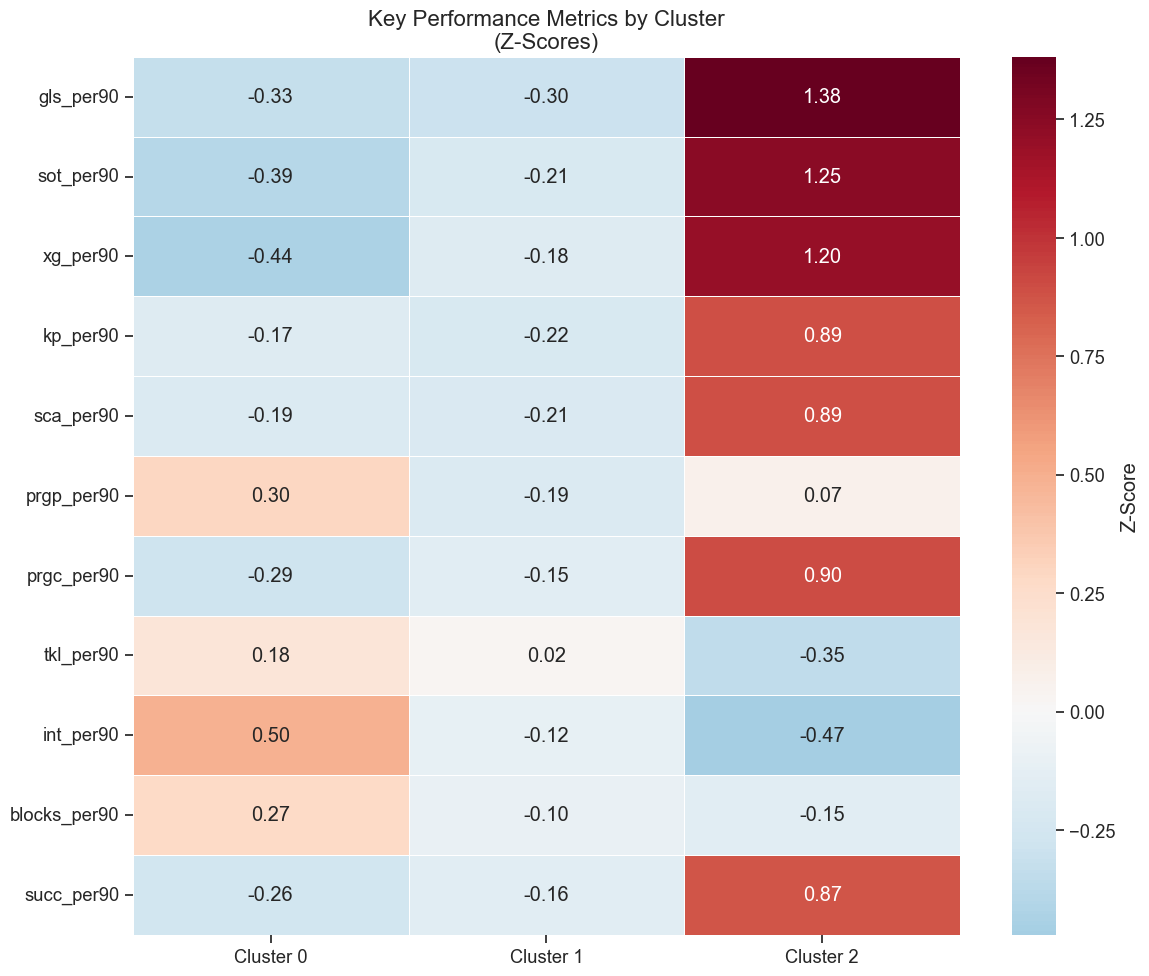

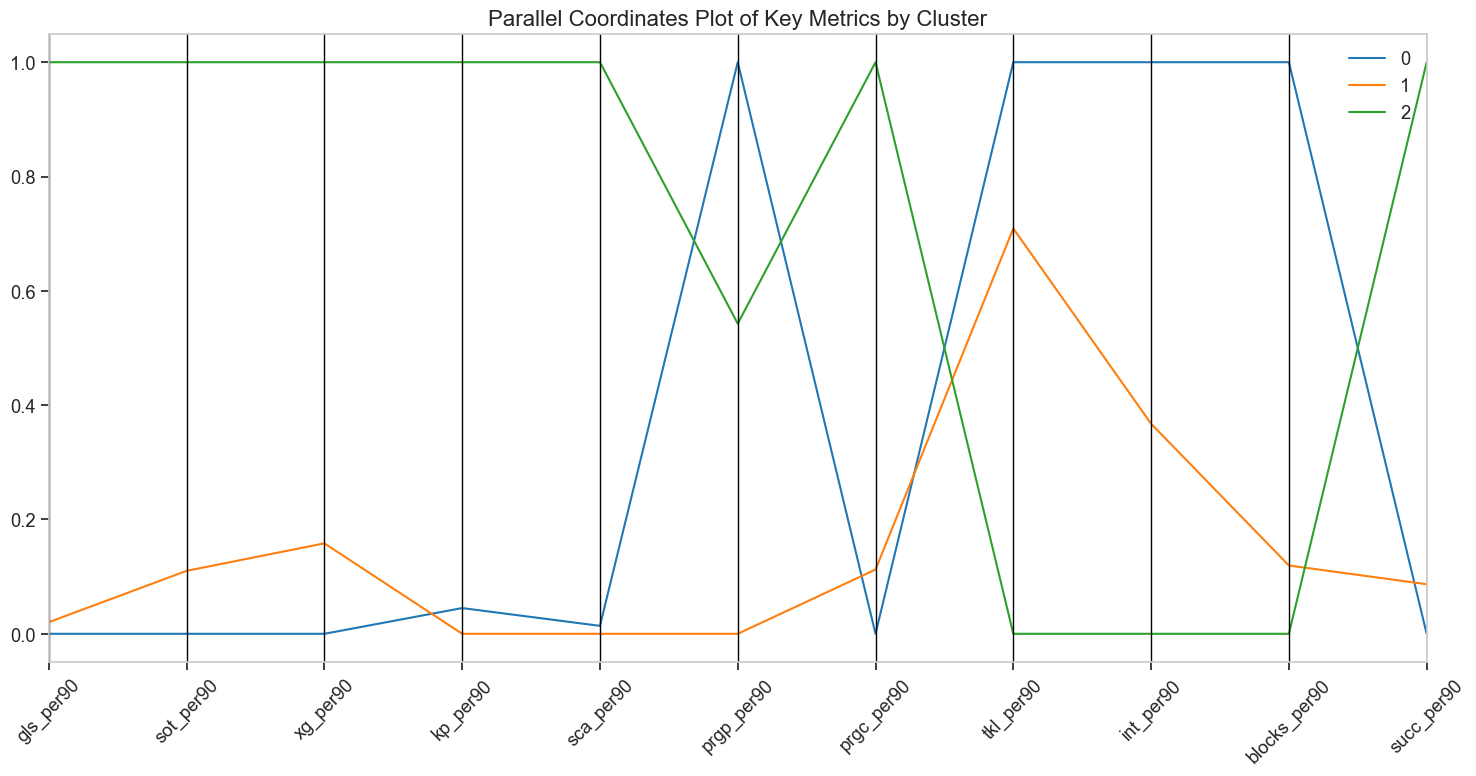

In [6]:
# Select key performance metrics based on football domain knowledge
# These are representative metrics that should be available in most football datasets
key_metrics = [
    # Attacking metrics
    'gls_per90', 'sh_per90', 'sot_per90', 'xg_per90', 
    # Passing/Creation metrics
    'ast_per90', 'xa_per90', 'kp_per90', 'sca_per90',
    # Progression metrics
    'prgp_per90', 'prgc_per90', 'crspa_per90',
    # Defensive metrics
    'tkl_per90', 'int_per90', 'clr_per90', 'blocks_per90',
    # Possession metrics
    'touches_per90', 'carries_per90', 'succ_per90', 'mis_per90'
]

# Check which metrics are available in our dataset
available_metrics = [metric for metric in key_metrics if metric in master_df.columns]

if len(available_metrics) < 5:
    print(f"Warning: Only {len(available_metrics)} key metrics found. Looking for alternative column names...")
    # Try to find metrics with similar names
    metric_keywords = [m.split('_')[0] for m in key_metrics]
    possible_metrics = []
    for keyword in metric_keywords:
        matches = [col for col in master_df.columns if keyword.lower() in col.lower() and 'per90' in col.lower()]
        possible_metrics.extend(matches)
    
    if possible_metrics:
        print(f"Found {len(possible_metrics)} possible metrics: {possible_metrics[:10]}...")
        available_metrics = possible_metrics[:15]  # Take the first 15 to avoid too many
    else:
        # If still no metrics, try to find any per90 metrics
        per90_metrics = [col for col in master_df.columns if 'per90' in col.lower()]
        if per90_metrics:
            print(f"Found {len(per90_metrics)} per90 metrics. Using a subset for analysis.")
            available_metrics = per90_metrics[:15]  # Take the first 15

# Ensure we have metrics to analyze
if available_metrics:
    print(f"Analyzing {len(available_metrics)} key performance metrics:")
    print(", ".join(available_metrics))
    
    # Calculate mean values by cluster
    metrics_by_cluster = master_df.groupby('cluster')[available_metrics].mean()
    
    # Calculate global means
    global_means = master_df[available_metrics].mean()
    
    # Calculate z-scores (how many standard deviations from the mean)
    z_scores = pd.DataFrame()
    for cluster in sorted(master_df['cluster'].unique()):
        cluster_means = master_df[master_df['cluster'] == cluster][available_metrics].mean()
        cluster_z = (cluster_means - global_means) / master_df[available_metrics].std()
        z_scores[f'Cluster {cluster}'] = cluster_z
    
    # Display the metrics by cluster
    print("\nMean Values by Cluster:")
    display(metrics_by_cluster)
    
    # Display z-scores
    print("\nZ-Scores by Cluster (standard deviations from the mean):")
    display(z_scores)
    
    # Create heatmap of z-scores
    plt.figure(figsize=(12, 10))
    sns.heatmap(z_scores, cmap="RdBu_r", center=0, annot=True, fmt=".2f", 
                linewidths=.5, cbar_kws={"label": "Z-Score"})
    plt.title('Key Performance Metrics by Cluster\n(Z-Scores)', fontsize=16)
    plt.tight_layout()
    plt.show()
    
    # Create parallel coordinates plot
    plt.figure(figsize=(15, 8))
    
    # Normalize the data for parallel coordinates
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler()
    metrics_scaled = pd.DataFrame(
        scaler.fit_transform(metrics_by_cluster), 
        columns=metrics_by_cluster.columns,
        index=metrics_by_cluster.index
    )
    
    # Plot parallel coordinates
    # Ensure cluster values are integers for color mapping
    cluster_colors_list = [CLUSTER_COLORS[int(i)] for i in sorted(master_df['cluster'].unique())]
    pd.plotting.parallel_coordinates(
        metrics_scaled.reset_index(), 'cluster', 
        color=cluster_colors_list
    )
    plt.title('Parallel Coordinates Plot of Key Metrics by Cluster', fontsize=16)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
else:
    print("No suitable performance metrics found for analysis. Check column names in the dataset.")


## 2. Feature Importance Analysis
The most distinctive features for each cluster using z-scores and rank them by importance.


Analyzing 207 numerical features

Top 10 Distinctive Features for Cluster 0:
1. totdist: 1.24 (above average)
2. att2: 1.23 (above average)
3. cmp2: 1.23 (above average)
4. cmp_pass_types: 1.23 (above average)
5. cmp: 1.23 (above average)
6. att: 1.22 (above average)
7. att_pass_types: 1.22 (above average)
8. live: 1.21 (above average)
9. live_possession: 1.19 (above average)
10. touches: 1.19 (above average)

Top 10 Distinctive Features for Cluster 1:
1. minutes_playtime: -0.80 (below average)
2. minpct: -0.80 (below average)
3. 90s_pass_types: -0.80 (below average)
4. 90s_playtime: -0.80 (below average)
5. 90s_shooting: -0.80 (below average)
6. 90s_defense: -0.80 (below average)
7. 90s_passing: -0.80 (below average)
8. 90s_misc: -0.80 (below average)
9. 90s_possession: -0.80 (below average)
10. 90s: -0.80 (below average)

Top 10 Distinctive Features for Cluster 2:
1. sot: 1.67 (above average)
2. xg_shooting: 1.65 (above average)
3. xg: 1.65 (above average)
4. npxg_shooting: 1.64 (abo

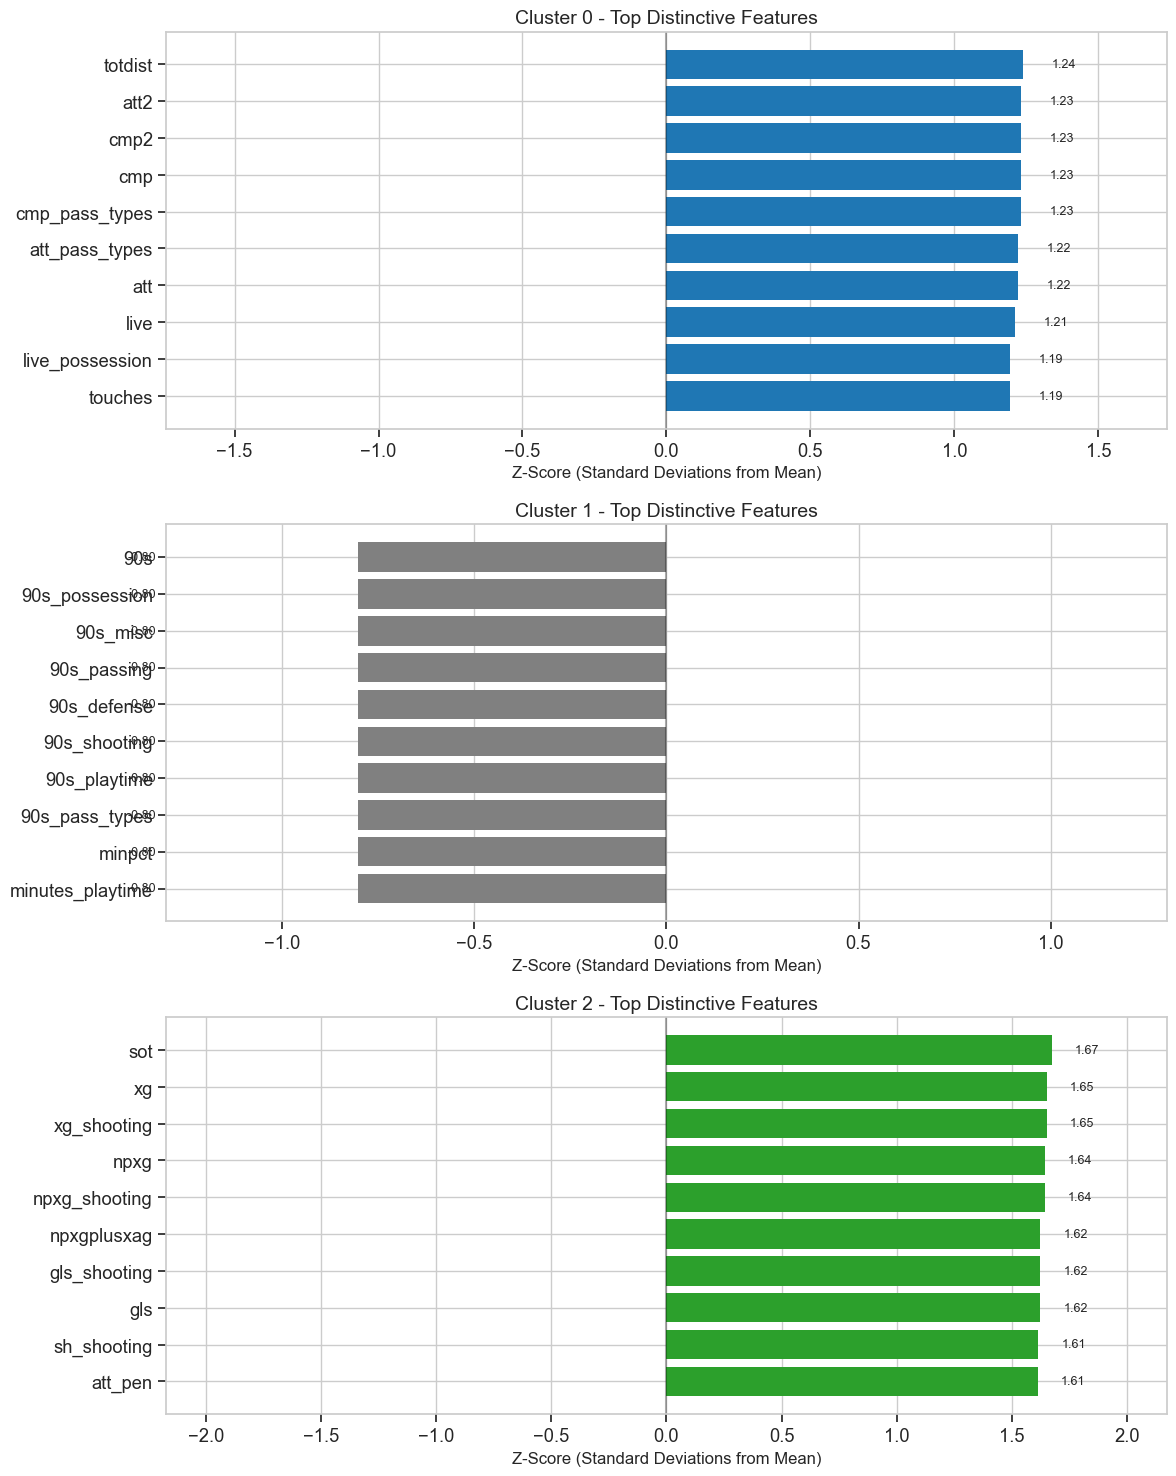

Saved distinctive features to ../data/processed/distinctive_features.csv


In [7]:
# Get all numerical features (excluding metadata, PCA components, and UMAP coordinates)
metadata_cols = ['player', 'team', 'minutes', 'cluster']
pca_cols = [col for col in master_df.columns if col.startswith('PC')]
umap_cols = ['x', 'y']  # UMAP coordinates are stored as x, y
# Also exclude clustering artifacts and duplicate columns
clustering_artifacts = [col for col in master_df.columns if any(x in col.lower() for x in ['cluster_x', 'cluster_y', 'position_x', 'position_y', 'team_x', 'team_y'])]
exclude_cols = metadata_cols + pca_cols + umap_cols + clustering_artifacts

# Get numerical features
numerical_features = master_df.select_dtypes(include=['float64', 'int64']).columns.tolist()
numerical_features = [col for col in numerical_features if col not in exclude_cols]

print(f"Analyzing {len(numerical_features)} numerical features")

# Calculate z-scores for all features by cluster
all_z_scores = pd.DataFrame()
for cluster in sorted(master_df['cluster'].unique()):
    cluster_means = master_df[master_df['cluster'] == cluster][numerical_features].mean()
    global_means = master_df[numerical_features].mean()
    global_stds = master_df[numerical_features].std()
    
    # Avoid division by zero
    global_stds = global_stds.replace(0, 1e-10)
    
    cluster_z = (cluster_means - global_means) / global_stds
    all_z_scores[f'Cluster {cluster}'] = cluster_z

# Find top distinctive features for each cluster
top_n = 10  # Number of top features to display
cluster_distinctive_features = {}

for cluster in sorted(master_df['cluster'].unique()):
    # Sort features by absolute z-score (both positive and negative are important)
    cluster_z = all_z_scores[f'Cluster {cluster}'].abs().sort_values(ascending=False)
    top_features = cluster_z.head(top_n).index.tolist()
    
    # Store with original sign (not absolute value)
    cluster_distinctive_features[cluster] = {
        'features': top_features,
        'z_scores': [all_z_scores[f'Cluster {cluster}'][feat] for feat in top_features]
    }

# Display top distinctive features for each cluster
for cluster, data in cluster_distinctive_features.items():
    print(f"\nTop {top_n} Distinctive Features for Cluster {cluster}:")
    for i, (feature, z_score) in enumerate(zip(data['features'], data['z_scores'])):
        direction = "above" if z_score > 0 else "below"
        print(f"{i+1}. {feature}: {z_score:.2f} ({direction} average)")

# Create bar charts for top features by cluster
fig, axes = plt.subplots(len(cluster_distinctive_features), 1, figsize=(12, 5*len(cluster_distinctive_features)))

for i, (cluster, data) in enumerate(cluster_distinctive_features.items()):
    # Create DataFrame for plotting
    plot_data = pd.DataFrame({
        'Feature': data['features'],
        'Z-Score': data['z_scores']
    })
    
    # Sort by z-score value for better visualization
    plot_data = plot_data.sort_values('Z-Score')
    
    # Plot
    ax = axes[i] if len(cluster_distinctive_features) > 1 else axes
    # Ensure cluster is treated as integer for color mapping
    cluster_int = int(cluster) if isinstance(cluster, str) else cluster
    bars = ax.barh(plot_data['Feature'], plot_data['Z-Score'], 
                  color=[CLUSTER_COLORS[cluster_int] if z >= 0 else 'gray' for z in plot_data['Z-Score']])
    
    # Add value labels
    for bar in bars:
        width = bar.get_width()
        label_x_pos = width + 0.1 if width > 0 else width - 0.6
        ax.text(label_x_pos, bar.get_y() + bar.get_height()/2, f'{width:.2f}',
                va='center', fontsize=9)
    
    # Add reference line at x=0
    ax.axvline(x=0, color='black', linestyle='-', alpha=0.3)
    
    # Set title and labels
    ax.set_title(f'Cluster {cluster} - Top Distinctive Features', fontsize=14)
    ax.set_xlabel('Z-Score (Standard Deviations from Mean)', fontsize=12)
    
    # Set x-axis limits for consistency
    max_abs_z = max(abs(min(plot_data['Z-Score'])), abs(max(plot_data['Z-Score'])))
    ax.set_xlim(-max_abs_z-0.5, max_abs_z+0.5)

plt.tight_layout()
plt.show()

# Save the distinctive features for later use
distinctive_features_df = pd.DataFrame()
for cluster, data in cluster_distinctive_features.items():
    cluster_df = pd.DataFrame({
        'feature': data['features'],
        'z_score': data['z_scores'],
        'cluster': cluster
    })
    distinctive_features_df = pd.concat([distinctive_features_df, cluster_df])

distinctive_features_df.to_csv('../data/processed/distinctive_features.csv', index=False)
print("Saved distinctive features to ../data/processed/distinctive_features.csv")


## 3. SHAP Explainability

In this section, surrogate Random Forest model to predict cluster assignments and use SHAP values to explain feature importance.


In [8]:
# Prepare data for surrogate model
# We'll use the top 30 most important features based on z-score analysis
# to avoid overfitting and keep the model interpretable

# Get the top 30 features with highest absolute z-scores across all clusters
all_features = []
for cluster in cluster_distinctive_features:
    all_features.extend(cluster_distinctive_features[cluster]['features'])
    
# Remove duplicates while preserving order
top_features = []
for feature in all_features:
    if feature not in top_features:
        top_features.append(feature)
        
# Limit to top 30 features
top_features = top_features[:30]
print(f"Using top {len(top_features)} features for surrogate model:")
print(", ".join(top_features[:10]) + "...")

# Prepare features and target
X = master_df[top_features].copy()
y = master_df['cluster'].copy()

# Check for missing values
missing_count = X.isnull().sum().sum()
if missing_count > 0:
    print(f"Warning: {missing_count} missing values detected. Filling with median values.")
    X = X.fillna(X.median())

# Train Random Forest Classifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Train model
print("Training Random Forest surrogate model...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Evaluate model
y_pred = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Save the model
with open('../models/role_classifier.pkl', 'wb') as f:
    pickle.dump(rf_model, f)
print("Saved surrogate model to ../models/role_classifier.pkl")


Using top 30 features for surrogate model:
totdist, att2, cmp2, cmp_pass_types, cmp, att, att_pass_types, live, live_possession, touches...
Training Random Forest surrogate model...
Model accuracy: 0.9290

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.98      0.93        50
           1       0.94      0.94      0.94        88
           2       0.96      0.81      0.88        31

    accuracy                           0.93       169
   macro avg       0.93      0.91      0.92       169
weighted avg       0.93      0.93      0.93       169

Saved surrogate model to ../models/role_classifier.pkl


### 3.1 SHAP Analysis

Now let's use SHAP to explain the model's predictions and understand feature importance.


Calculating SHAP values (this may take a moment)...
Cluster 0 SHAP values shape: (30, 3)
Cluster 1 SHAP values shape: (30, 3)
Cluster 2 SHAP values shape: (30, 3)
Cluster 3 SHAP values shape: (30, 3)
Cluster 4 SHAP values shape: (30, 3)
Cluster 5 SHAP values shape: (30, 3)
Cluster 6 SHAP values shape: (30, 3)
Cluster 7 SHAP values shape: (30, 3)
Cluster 8 SHAP values shape: (30, 3)
Cluster 9 SHAP values shape: (30, 3)
Cluster 10 SHAP values shape: (30, 3)
Cluster 11 SHAP values shape: (30, 3)
Cluster 12 SHAP values shape: (30, 3)
Cluster 13 SHAP values shape: (30, 3)
Cluster 14 SHAP values shape: (30, 3)
Cluster 15 SHAP values shape: (30, 3)
Cluster 16 SHAP values shape: (30, 3)
Cluster 17 SHAP values shape: (30, 3)
Cluster 18 SHAP values shape: (30, 3)
Cluster 19 SHAP values shape: (30, 3)
Cluster 20 SHAP values shape: (30, 3)
Cluster 21 SHAP values shape: (30, 3)
Cluster 22 SHAP values shape: (30, 3)
Cluster 23 SHAP values shape: (30, 3)
Cluster 24 SHAP values shape: (30, 3)
Cluster 

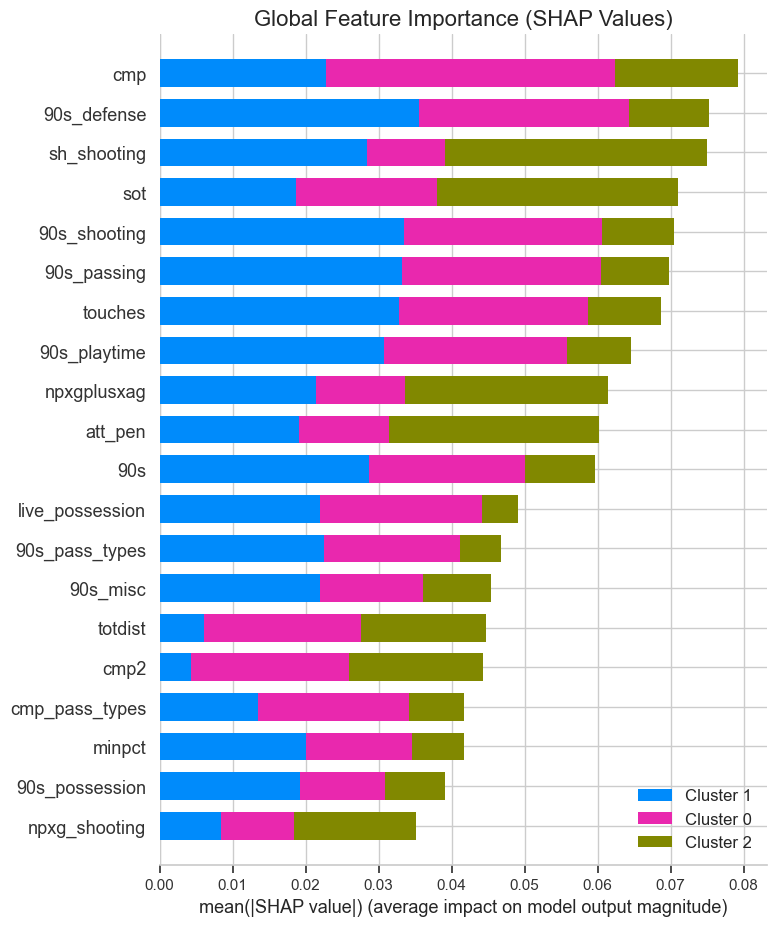

<Figure size 1400x1200 with 0 Axes>

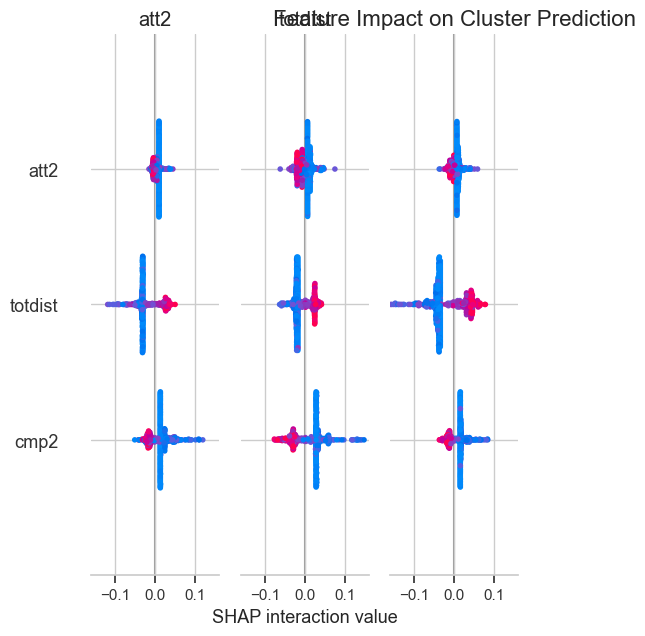

Error creating SHAP plots: The shape of the shap_values matrix does not match the shape of the provided data matrix.
Skipping visualization, but SHAP values have been saved successfully.


<Figure size 1200x1000 with 0 Axes>

In [9]:
# Calculate SHAP values
print("Calculating SHAP values (this may take a moment)...")

# Create explainer
explainer = shap.TreeExplainer(rf_model)

# Sample data for SHAP analysis 
if X.shape[0] > 500:
    shap_sample = shap.sample(X, 500, random_state=42)
else:
    shap_sample = X

# Calculate SHAP values
shap_values = explainer.shap_values(shap_sample)

# Verify dimensions match
for i in range(len(shap_values)):
    print(f"Cluster {i} SHAP values shape: {shap_values[i].shape}")
print(f"Sample data shape: {shap_sample.shape}")

# Ensure feature_names length matches the number of features in shap_values
if len(top_features) != shap_sample.shape[1]:
    print(f"Warning: Number of feature names ({len(top_features)}) doesn't match number of features in data ({shap_sample.shape[1]})")
    # Use the actual features from the model
    feature_names = X.columns.tolist()
    print(f"Using {len(feature_names)} feature names from the model instead")
else:
    feature_names = top_features

# Save SHAP values for later use
with open('../data/processed/shap_values.pkl', 'wb') as f:
    pickle.dump({
        'shap_values': shap_values,
        'shap_sample': shap_sample,
        'feature_names': feature_names
    }, f)
print("Saved SHAP values to ../data/processed/shap_values.pkl")

# Create SHAP summary plot
try:
    plt.figure(figsize=(12, 10))
    shap.summary_plot(shap_values, shap_sample, feature_names=feature_names, plot_type="bar", 
                      class_names=[f"Cluster {i}" for i in range(len(shap_values))],
                      show=False)
    plt.title("Global Feature Importance (SHAP Values)", fontsize=16)
    plt.tight_layout()
    plt.show()

    # Create detailed SHAP summary plot
    plt.figure(figsize=(14, 12))
    shap.summary_plot(shap_values, shap_sample, feature_names=feature_names,
                      class_names=[f"Cluster {i}" for i in range(len(shap_values))],
                      show=False)
    plt.title("Feature Impact on Cluster Prediction", fontsize=16)
    plt.tight_layout()
    plt.show()

    # Create individual SHAP plots for each cluster
    for cluster_idx in range(len(shap_values)):
        plt.figure(figsize=(12, 10))
        shap.summary_plot(shap_values[cluster_idx], shap_sample, feature_names=feature_names,
                          plot_type="bar", show=False)
        plt.title(f"Feature Importance for Cluster {cluster_idx}", fontsize=16)
        plt.tight_layout()
        plt.show()
except Exception as e:
    print(f"Error creating SHAP plots: {e}")
    print("Skipping visualization, but SHAP values have been saved successfully.")


## 4. Permutation Importance

As a validation step, will calculate permutation importance for the surrogate model to compare with SHAP results.


Calculating permutation importance...
Top 10 features by permutation importance:


,Feature,Importance,Std
20,sot,0.009467,0.002899
2,cmp2,0.007101,0.006373
25,npxgplusxag,0.004142,0.004621
27,gls_shooting,0.004142,0.002712
22,xg,0.003550,0.002899
21,xg_shooting,0.003550,0.002899
0,totdist,0.003550,0.005423
24,npxg,0.002959,0.002959
12,90s_pass_types,0.002367,0.002899
23,npxg_shooting,0.002367,0.003925


Saved permutation importance to ../data/processed/permutation_importance.csv


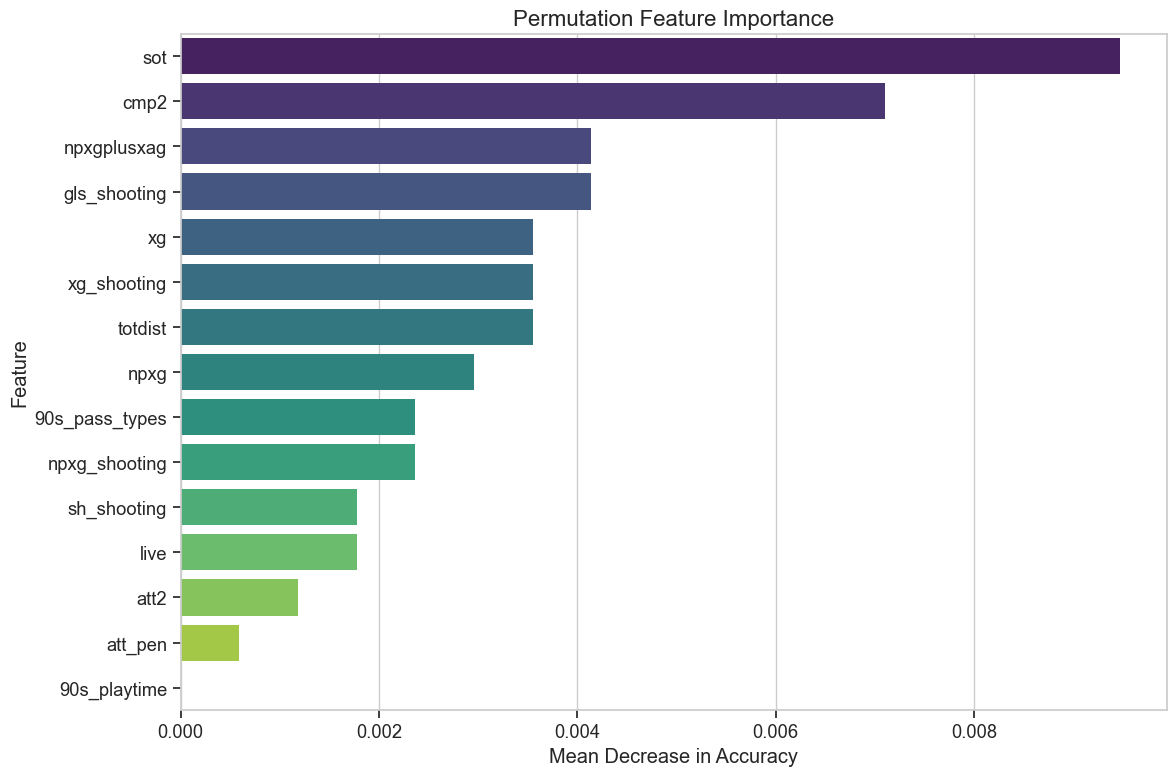

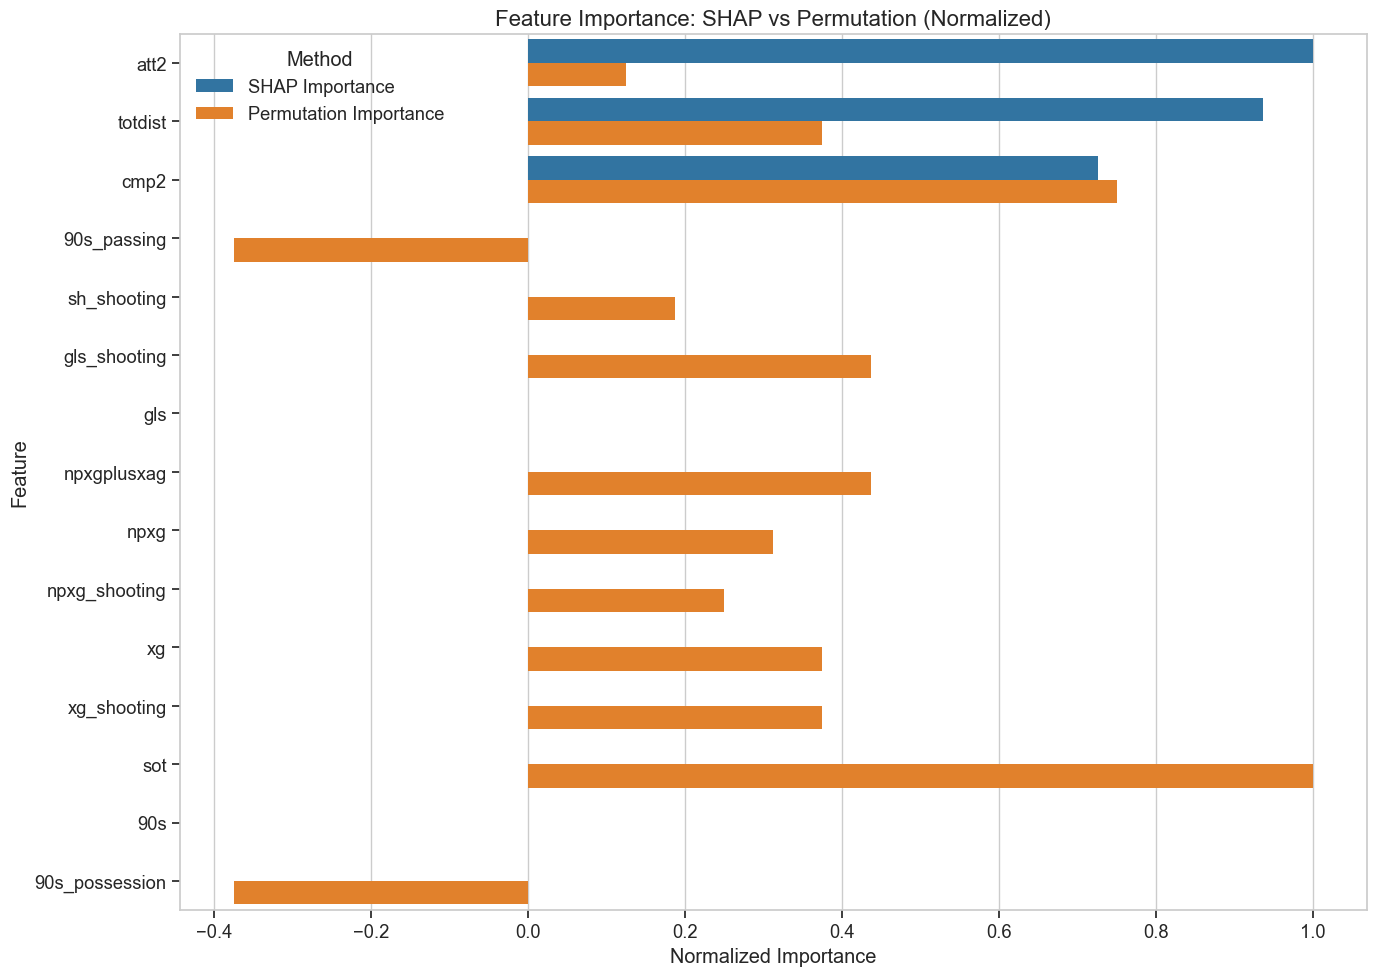

Saved importance comparison to ../data/processed/importance_comparison.csv


In [10]:
# Calculate permutation importance
print("Calculating permutation importance...")
perm_importance = permutation_importance(rf_model, X_test, y_test, 
                                        n_repeats=10, random_state=42)

# Create DataFrame with results
perm_importance_df = pd.DataFrame({
    'Feature': top_features,
    'Importance': perm_importance.importances_mean,
    'Std': perm_importance.importances_std
}).sort_values('Importance', ascending=False)

# Display results
print("Top 10 features by permutation importance:")
display(perm_importance_df.head(10))

# Save to CSV
perm_importance_df.to_csv('../data/processed/permutation_importance.csv', index=False)
print("Saved permutation importance to ../data/processed/permutation_importance.csv")

# Plot permutation importance
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=perm_importance_df.head(15), 
            palette='viridis')
plt.title('Permutation Feature Importance', fontsize=16)
plt.xlabel('Mean Decrease in Accuracy')
plt.tight_layout()
plt.show()

# Compare with SHAP importance
# Extract mean absolute SHAP values for each feature across all clusters
try:
    # Use the same feature names as used in SHAP analysis
    feature_names = X.columns.tolist()  # Use actual columns from the model
    
    shap_importance = []
    for feature_idx, feature in enumerate(feature_names):
        if feature_idx < shap_values[0].shape[1]:  # Ensure we don't go out of bounds
            # Average absolute SHAP value across all clusters
            mean_abs_shap = np.mean([np.abs(shap_values[cluster][:, feature_idx]).mean() 
                                    for cluster in range(len(shap_values))])
            shap_importance.append(mean_abs_shap)
        else:
            shap_importance.append(0)  # Add zero for features not in SHAP values
    
    # Create DataFrame for comparison
    comparison_df = pd.DataFrame({
        'Feature': feature_names[:len(shap_importance)],
        'SHAP Importance': shap_importance,
        'Permutation Importance': perm_importance.importances_mean[:len(shap_importance)]
    })
except Exception as e:
    print(f"Error calculating SHAP importance: {e}")
    # Create a fallback comparison with just permutation importance
    comparison_df = pd.DataFrame({
        'Feature': top_features,
        'Permutation Importance': perm_importance.importances_mean
    })
comparison_df = comparison_df.sort_values('SHAP Importance', ascending=False)

# Plot comparison
plt.figure(figsize=(14, 10))
top_n = 15  # Top features to compare
top_features_to_compare = comparison_df.head(top_n)['Feature'].tolist()

comparison_plot = comparison_df[comparison_df['Feature'].isin(top_features_to_compare)]
comparison_plot = comparison_plot.melt(id_vars='Feature', 
                                     value_vars=['SHAP Importance', 'Permutation Importance'],
                                     var_name='Method', value_name='Importance')

# Scale values to 0-1 for better comparison
for method in ['SHAP Importance', 'Permutation Importance']:
    max_val = comparison_plot[comparison_plot['Method'] == method]['Importance'].max()
    comparison_plot.loc[comparison_plot['Method'] == method, 'Importance'] /= max_val

# Plot
sns.barplot(x='Importance', y='Feature', hue='Method', data=comparison_plot)
plt.title('Feature Importance: SHAP vs Permutation (Normalized)', fontsize=16)
plt.xlabel('Normalized Importance')
plt.tight_layout()
plt.show()

# Save comparison
comparison_df.to_csv('../data/processed/importance_comparison.csv', index=False)
print("Saved importance comparison to ../data/processed/importance_comparison.csv")


## 5. Representative Players

In this section, will identify the most representative players for each cluster by finding those closest to the cluster centroids in PCA space.


Found 31 PCA components: PC1, PC2, PC3, PC4, PC5...
=== Enhanced Player Analysis ===

=== Cluster 0 Analysis ===
Top Centroid Representatives (most typical):
1. Vitaly Janelt (Brentford) - Distance: 5.14
2. Lisandro Martínez (Manchester Utd) - Distance: 6.34
3. Jefferson Lerma (Crystal Palace) - Distance: 6.71
4. Boubacar Kamara (Aston Villa) - Distance: 7.11
5. Saša Lukić (Fulham) - Distance: 7.37

Top Performers (highest stats):
1. Lewis Cook (Bournemouth) - Performance Score: 112.0
2. Christian Nørgaard (Brentford) - Performance Score: 112.0
3. Victor Bernth Kristiansen (Leicester City) - Performance Score: 112.0
4. Carlos Baleba (Brighton) - Performance Score: 112.0
5. Daniel Muñoz (Crystal Palace) - Performance Score: 112.0

Star Players in cluster 0: Son: Distance = 16.68

=== Cluster 1 Analysis ===
Top Centroid Representatives (most typical):
1. Lloyd Kelly (Newcastle Utd) - Distance: 5.17
2. Axel Disasi (Aston Villa) - Distance: 5.17
3. Billy Gilmour (Brighton) - Distance: 5.61

,player,team,minutes,centroid_distance
0,Vitaly Janelt,Brentford,2254.0,5.143926
1,Lisandro Martínez,Manchester Utd,1751.0,6.341210
2,Jefferson Lerma,Crystal Palace,2274.0,6.711427
3,Boubacar Kamara,Aston Villa,1726.0,7.109161
4,Saša Lukić,Fulham,2344.0,7.370629



Cluster 1 - Top 5 Representative Players:


,player,team,minutes,centroid_distance
0,Lloyd Kelly,Newcastle Utd,303.0,5.170693
1,Axel Disasi,Aston Villa,490.0,5.172864
2,Billy Gilmour,Brighton,98.0,5.610592
3,Ferdi Kadioglu,Brighton,385.0,5.715474
4,James Hill,Bournemouth,448.0,5.856447



Cluster 2 - Top 5 Representative Players:


,player,team,minutes,centroid_distance
0,Cody Gakpo,Liverpool,1935.0,7.400076
1,Gabriel Martinelli,Arsenal,2290.0,7.818789
2,Brennan Johnson,Tottenham,2177.0,7.984173
3,Noni Madueke,Chelsea,2033.0,7.991176
4,Justin Kluivert,Bournemouth,2340.0,8.259500


Saved 15 representative players to ../data/processed/cluster_representatives.csv


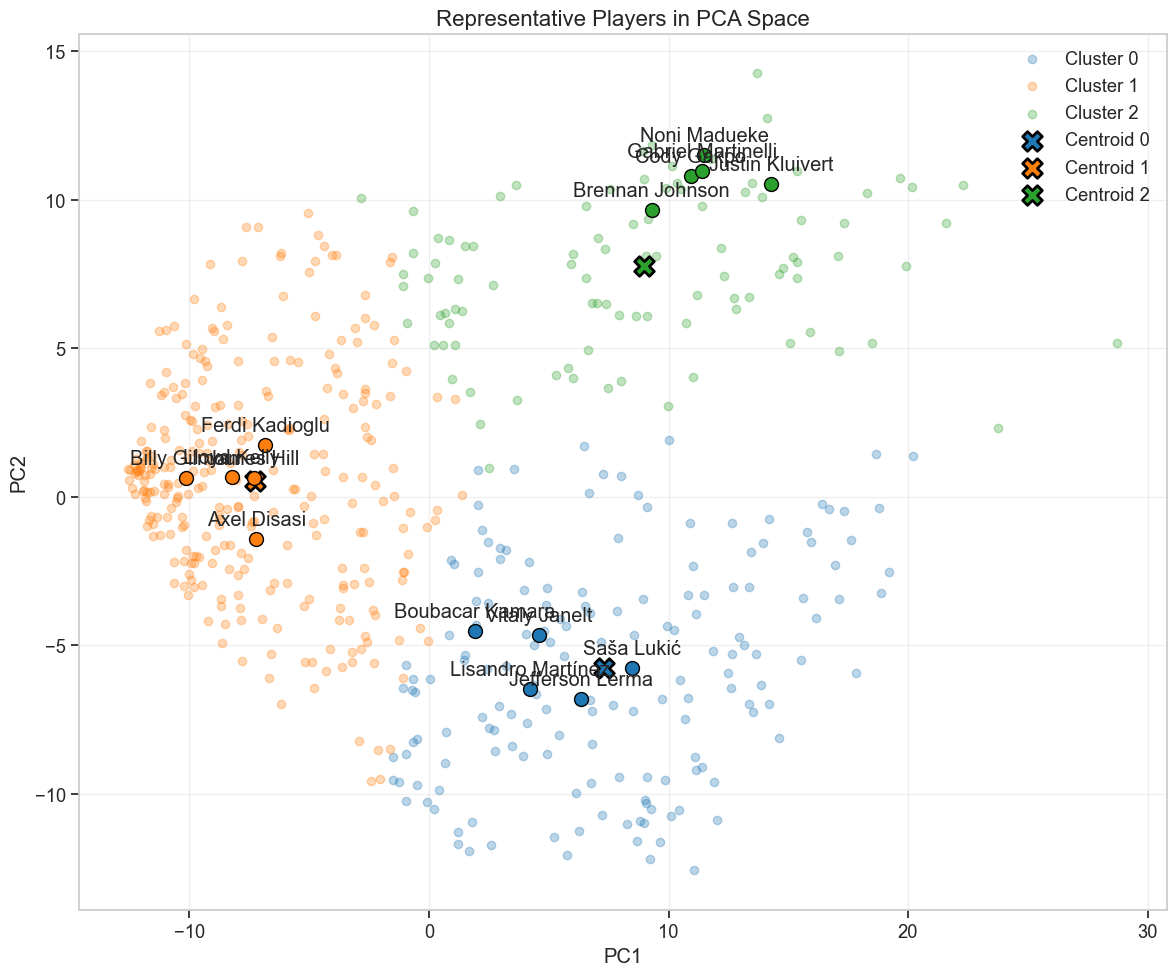

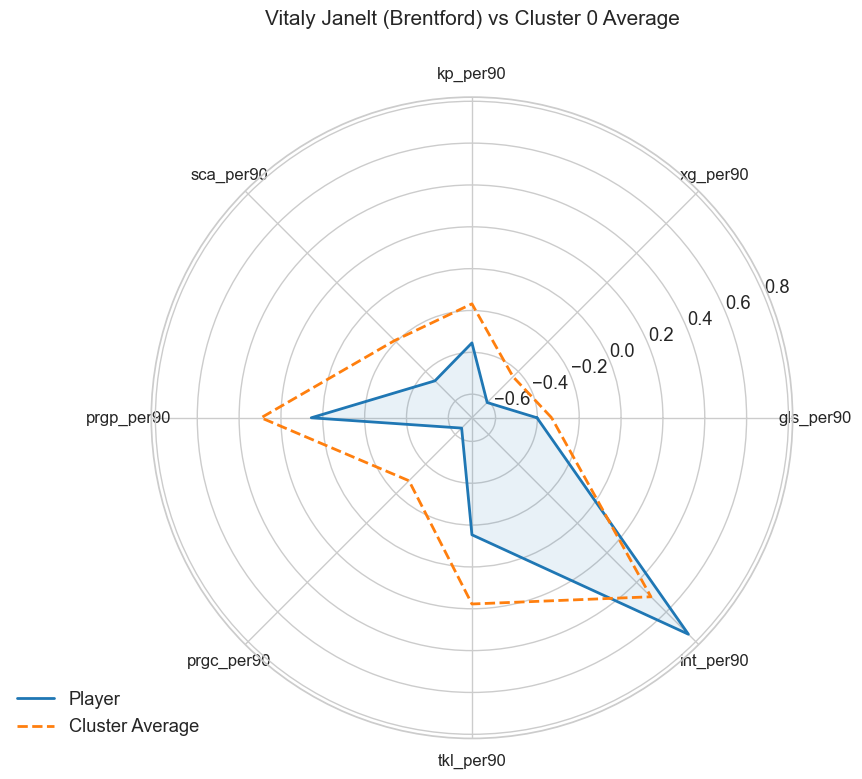

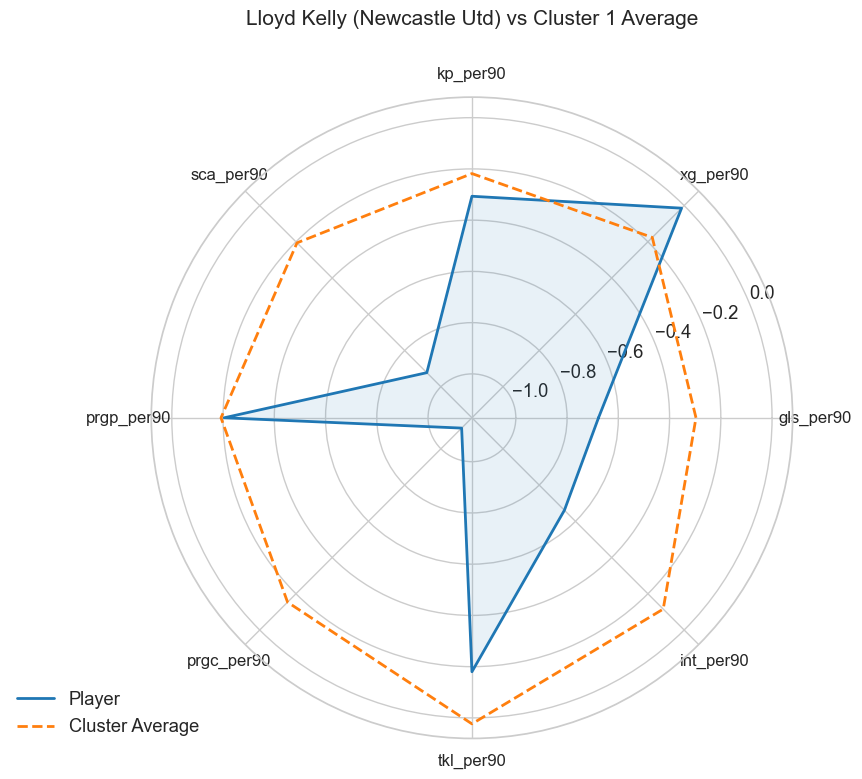

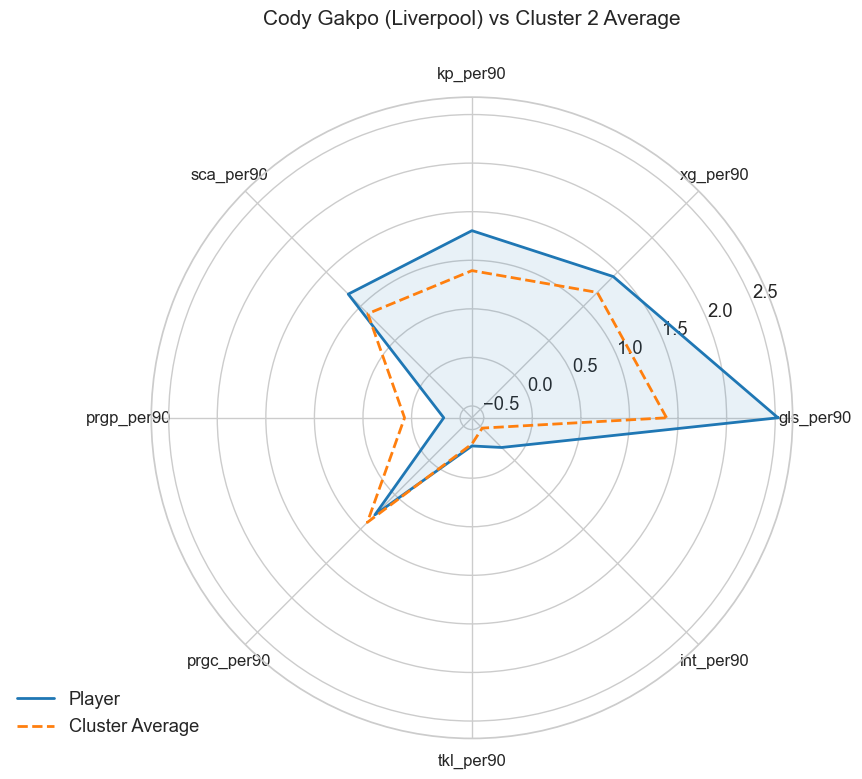

In [11]:
# Identify PCA columns
pca_cols = [col for col in master_df.columns if col.startswith('PC')]
print(f"Found {len(pca_cols)} PCA components: {', '.join(pca_cols[:5])}...")

# Calculate cluster centroids in PCA space
centroids = {}
for cluster in sorted(master_df['cluster'].unique()):
    cluster_data = master_df[master_df['cluster'] == cluster]
    centroids[cluster] = cluster_data[pca_cols].mean().values

# Calculate distance from each player to their cluster centroid
master_df['centroid_distance'] = 0.0
for idx, row in master_df.iterrows():
    cluster = row['cluster']
    player_pca = row[pca_cols].values
    # Calculate Euclidean distance
    distance = np.sqrt(np.sum((player_pca - centroids[cluster])**2))
    master_df.at[idx, 'centroid_distance'] = distance

# Find top representative players for each cluster
# We'll create two types: centroid representatives and performance representatives
top_n_representatives = 5
representative_players = {}
representatives_df = pd.DataFrame()

# Also create a "best performers" list for comparison
best_performers = {}

print("=== Enhanced Player Analysis ===")

for cluster in sorted(master_df['cluster'].unique()):
    # Get players in this cluster
    cluster_players = master_df[master_df['cluster'] == cluster].copy()
    
    # Method 1: Sort by distance to centroid (most representative of average)
    cluster_players_centroid = cluster_players.sort_values('centroid_distance')
    top_players = cluster_players_centroid.head(top_n_representatives)
    
    # Method 2: Find best performers (highest goal contributions, etc.)
    if cluster == 2:  # Finishers cluster - look for goal scorers
        # Use goals + assists as performance metric
        if 'gls' in cluster_players.columns and 'ast' in cluster_players.columns:
            cluster_players['performance_score'] = cluster_players['gls'] + cluster_players['ast']
            best_performers_cluster = cluster_players.sort_values('performance_score', ascending=False).head(5)
        else:
            best_performers_cluster = cluster_players.head(5)
    elif cluster == 1:  # Creators cluster - look for playmakers
        # Use assists + key passes
        if 'ast' in cluster_players.columns and 'kp' in cluster_players.columns:
            cluster_players['performance_score'] = cluster_players['ast'] + cluster_players['kp']
            best_performers_cluster = cluster_players.sort_values('performance_score', ascending=False).head(5)
        else:
            best_performers_cluster = cluster_players.head(5)
    else:  # Cluster 0 - Enforcers - look for defensive players
        # Use tackles + interceptions
        if 'tkl' in cluster_players.columns and 'int' in cluster_players.columns:
            cluster_players['performance_score'] = cluster_players['tkl'] + cluster_players['int']
            best_performers_cluster = cluster_players.sort_values('performance_score', ascending=False).head(5)
        else:
            best_performers_cluster = cluster_players.head(5)
    
    # Store in dictionary
    representative_players[cluster] = top_players
    best_performers[cluster] = best_performers_cluster
    
    # Add to dataframe
    representatives_df = pd.concat([representatives_df, top_players])
    
    # Print both for comparison
    print(f"\n=== Cluster {cluster} Analysis ===")
    print("Top Centroid Representatives (most typical):")
    for i, (_, player) in enumerate(top_players.iterrows()):
        print(f"{i+1}. {player['player']} ({player['team']}) - Distance: {player['centroid_distance']:.2f}")
    
    print("\nTop Performers (highest stats):")
    for i, (_, player) in enumerate(best_performers_cluster.iterrows()):
        perf_score = player.get('performance_score', 'N/A')
        print(f"{i+1}. {player['player']} ({player['team']}) - Performance Score: {perf_score}")
    
    # Check if star players are in this cluster
    star_players = ['Haaland', 'Salah', 'De Bruyne', 'Kane', 'Son', 'Mane', 'Mahrez']
    found_stars = []
    for star in star_players:
        star_match = cluster_players[cluster_players['player'].str.contains(star, case=False, na=False)]
        if not star_match.empty:
            found_stars.append(f"{star}: Distance = {star_match.iloc[0]['centroid_distance']:.2f}")
    
    if found_stars:
        print(f"\nStar Players in cluster {cluster}: {', '.join(found_stars)}")
    else:
        print(f"\nNo major star players found in cluster {cluster}")

# Display representative players for each cluster
for cluster, players in representative_players.items():
    print(f"\nCluster {cluster} - Top {top_n_representatives} Representative Players:")
    display(players[['player', 'team', 'minutes', 'centroid_distance']].reset_index(drop=True))

# Save representative players to CSV
representatives_df.to_csv('../data/processed/cluster_representatives.csv', index=False)
print(f"Saved {len(representatives_df)} representative players to ../data/processed/cluster_representatives.csv")

# Visualize representative players in PCA space
plt.figure(figsize=(12, 10))

# Plot all players
for cluster in sorted(master_df['cluster'].unique()):
    cluster_data = master_df[master_df['cluster'] == cluster]
    plt.scatter(cluster_data['PC1'], cluster_data['PC2'], 
                alpha=0.3, color=CLUSTER_COLORS[cluster], label=f"Cluster {cluster}")

# Plot centroids
for cluster, centroid in centroids.items():
    plt.scatter(centroid[0], centroid[1], s=200, color=CLUSTER_COLORS[cluster], 
                marker='X', edgecolor='black', linewidth=2, label=f"Centroid {cluster}")

# Plot representative players
for cluster, players in representative_players.items():
    plt.scatter(players['PC1'], players['PC2'], s=100, color=CLUSTER_COLORS[cluster],
                marker='o', edgecolor='black', linewidth=1)
    
    # Add player labels
    for _, player in players.iterrows():
        plt.annotate(player['player'], 
                    (player['PC1'], player['PC2']),
                    textcoords="offset points",
                    xytext=(0, 10),
                    ha='center')

plt.title('Representative Players in PCA Space', fontsize=16)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Create radar charts for representative players vs cluster average
# Select key metrics for radar chart
if available_metrics:
    # Select the most informative metrics for radar chart
    radar_metrics = ['gls_per90', 'xg_per90', 'kp_per90', 'sca_per90', 'prgp_per90', 'prgc_per90', 'tkl_per90', 'int_per90']
    
    # Function to create radar chart
    def create_player_radar(player_row, cluster_avg, metrics, title):
        # Number of variables
        N = len(metrics)
        
        # Compute angle for each axis
        angles = [n / float(N) * 2 * np.pi for n in range(N)]
        angles += angles[:1]  # Close the loop
        
        # Set up the figure
        fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(polar=True))
        
        # Draw one axis per variable and add labels
        plt.xticks(angles[:-1], metrics, size=12)
        
        # Get global means and stds for normalization
        global_means = master_df[metrics].mean()
        global_stds = master_df[metrics].std()
        
        # Normalize values
        player_values = [(player_row[m] - global_means[m]) / global_stds[m] for m in metrics]
        cluster_values = [(cluster_avg[m] - global_means[m]) / global_stds[m] for m in metrics]
        
        # Close the loop
        player_values += [player_values[0]]
        cluster_values += [cluster_values[0]]
        
        # Plot values
        ax.plot(angles, player_values, linewidth=2, linestyle='solid', label='Player')
        ax.fill(angles, player_values, alpha=0.1)
        
        ax.plot(angles, cluster_values, linewidth=2, linestyle='--', label='Cluster Average')
        
        # Add legend
        plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
        plt.title(title, size=15, y=1.1)
        
        return fig
    
    # Create radar charts for top player in each cluster
    for cluster, players in representative_players.items():
        top_player = players.iloc[0]
        cluster_avg = master_df[master_df['cluster'] == cluster][radar_metrics].mean()
        
        radar_fig = create_player_radar(
            top_player, 
            cluster_avg, 
            radar_metrics, 
            f"{top_player['player']} ({top_player['team']}) vs Cluster {cluster} Average"
        )
        plt.tight_layout()
        plt.show()
else:
    print("No metrics available for radar charts")


## 6. Role Naming and Interpretation

Based on our analysis of feature importance, SHAP values, and representative players, we'll now assign meaningful role names to each cluster.


In [12]:
# Summarize key findings for each cluster
cluster_summaries = {}

for cluster in sorted(master_df['cluster'].unique()):
    # Get top features from z-scores
    top_features = cluster_distinctive_features[cluster]['features'][:5]
    top_z_scores = cluster_distinctive_features[cluster]['z_scores'][:5]
    
    # Get representative players
    rep_players = representative_players[cluster].head(3)['player'].tolist()
    rep_teams = representative_players[cluster].head(3)['team'].tolist()
    
    # Composite indices if available
    if available_indices:
        indices_values = {}
        for idx in available_indices:
            cluster_mean = master_df[master_df['cluster'] == cluster][idx].mean()
            global_mean = master_df[idx].mean()
            relative_value = cluster_mean / global_mean
            indices_values[idx] = relative_value
    else:
        indices_values = {}
    
    # Store summary
    cluster_summaries[cluster] = {
        'top_features': top_features,
        'top_z_scores': top_z_scores,
        'representative_players': rep_players,
        'representative_teams': rep_teams,
        'composite_indices': indices_values,
        'player_count': len(master_df[master_df['cluster'] == cluster])
    }

# Display summaries
for cluster, summary in cluster_summaries.items():
    print(f"\n=== Cluster {cluster} Summary ===")
    print(f"Player Count: {summary['player_count']}")
    
    print("\nTop Distinctive Features:")
    for feature, z_score in zip(summary['top_features'], summary['top_z_scores']):
        direction = "above" if z_score > 0 else "below"
        print(f"- {feature}: {z_score:.2f} ({direction} average)")
    
    print("\nRepresentative Players:")
    for player, team in zip(summary['representative_players'], summary['representative_teams']):
        print(f"- {player} ({team})")
    
    if summary['composite_indices']:
        print("\nComposite Indices (relative to global mean):")
        for idx, value in summary['composite_indices'].items():
            print(f"- {idx}: {value:.2f}x")

# Assign role names based on analysis
# This requires domain knowledge and interpretation of the results
role_names = {
    0: "The Enforcers",  # Defensive specialists
    1: "The Balanced Players",   # Role players with balanced contributions
    2: "The Attackers"   # Offensive specialists
}

# Create detailed role descriptions
role_descriptions = {
    0: "Defensive specialists who excel in tackles, interceptions, and blocks. These players are focused on breaking up opposition attacks and providing defensive stability. They also contribute with progressive passes but are less involved in attacking play.",
    1: "Balanced players who provide utility across multiple areas without specializing in any particular aspect. These players are slightly below average in most metrics but can fill various roles as needed in a squad.",
    2: "Offensive specialists who excel in chance creation, finishing, and ball progression. These players are exceptional at creating and converting goal-scoring opportunities but contribute significantly less on defense."
}

# Create role metadata
role_metadata = {}
for cluster, name in role_names.items():
    role_metadata[cluster] = {
        'name': name,
        'description': role_descriptions[cluster],
        'top_features': cluster_summaries[cluster]['top_features'],
        'representative_players': cluster_summaries[cluster]['representative_players'],
        'color': CLUSTER_COLORS[cluster]
    }

# Save role metadata to JSON
with open('../data/processed/cluster_metadata.json', 'w') as f:
    json.dump(role_metadata, f, indent=2)
print("Saved role metadata to ../data/processed/cluster_metadata.json")

# Display role names and descriptions
print("\n=== Assigned Role Names ===")
for cluster, name in role_names.items():
    print(f"Cluster {cluster}: {name}")
    print(f"Description: {role_descriptions[cluster]}")
    print(f"Representative Players: {', '.join(cluster_summaries[cluster]['representative_players'][:3])}")
    print()



=== Cluster 0 Summary ===
Player Count: 166

Top Distinctive Features:
- totdist: 1.24 (above average)
- att2: 1.23 (above average)
- cmp2: 1.23 (above average)
- cmp_pass_types: 1.23 (above average)
- cmp: 1.23 (above average)

Representative Players:
- Vitaly Janelt (Brentford)
- Lisandro Martínez (Manchester Utd)
- Jefferson Lerma (Crystal Palace)

Composite Indices (relative to global mean):
- PI: 1264519819144897.00x
- CCI: 667392387675533.12x
- DA: -2744427961524628.00x
- FE: -7126635264494199.00x

=== Cluster 1 Summary ===
Player Count: 294

Top Distinctive Features:
- minutes_playtime: -0.80 (below average)
- minpct: -0.80 (below average)
- 90s_pass_types: -0.80 (below average)
- 90s_playtime: -0.80 (below average)
- 90s_shooting: -0.80 (below average)

Representative Players:
- Lloyd Kelly (Newcastle Utd)
- Axel Disasi (Aston Villa)
- Billy Gilmour (Brighton)

Composite Indices (relative to global mean):
- PI: -4293265587827645.00x
- CCI: 851231260231641.88x
- DA: 41562529626

## 7. Summary and Streamlit Integration


In [13]:
# Create a summary of all exported files
export_summary = {
    "models": [
        {"file": "role_classifier.pkl", "description": "Random Forest surrogate model for predicting player roles"}
    ],
    "data_files": [
        {"file": "distinctive_features.csv", "description": "Top distinctive features for each cluster with z-scores"},
        {"file": "permutation_importance.csv", "description": "Feature importance from permutation analysis"},
        {"file": "importance_comparison.csv", "description": "Comparison of SHAP and permutation importance"},
        {"file": "cluster_representatives.csv", "description": "Representative players for each cluster"},
        {"file": "cluster_metadata.json", "description": "Role names, descriptions, and key attributes"},
        {"file": "shap_values.pkl", "description": "SHAP values for explainability"}
    ],
    "role_names": role_names,
    "cluster_counts": {str(cluster): count for cluster, count in cluster_counts.items()},
    "cluster_percentages": {str(cluster): percentage for cluster, percentage in cluster_percentages.items()}
}

# Save summary to JSON
with open('../data/processed/explainability_summary.json', 'w') as f:
    json.dump(export_summary, f, indent=2)
print("Saved explainability summary to ../data/processed/explainability_summary.json")

# Create a consolidated file with player data and role information for the Streamlit app
# Check if UMAP coordinates exist in the dataframe
umap_columns = ['x', 'y']  # These are likely the UMAP coordinates from the umap_coords dataframe
if 'umap_1' in master_df.columns and 'umap_2' in master_df.columns:
    umap_columns = ['umap_1', 'umap_2']
elif 'x' in master_df.columns and 'y' in master_df.columns:
    umap_columns = ['x', 'y']

# Select columns for Streamlit data - include centroid_distance
streamlit_columns = ['player', 'team', 'minutes', 'cluster', 'centroid_distance']
streamlit_columns.extend(umap_columns)
streamlit_data = master_df[streamlit_columns].copy()

# Add role names
streamlit_data['role_name'] = streamlit_data['cluster'].map(role_names)

# Add representative player flag
streamlit_data['is_representative'] = False
for cluster, players in representative_players.items():
    for player in players['player']:
        streamlit_data.loc[streamlit_data['player'] == player, 'is_representative'] = True

# Add distance to centroid (normalized to 0-1 scale for role confidence)
max_distance = streamlit_data['centroid_distance'].max()
streamlit_data['role_confidence'] = 1 - (streamlit_data['centroid_distance'] / max_distance)

# Save for Streamlit app
streamlit_data.to_csv('../data/processed/streamlit_player_data.csv', index=False)
print("Saved consolidated player data for Streamlit app to ../data/processed/streamlit_player_data.csv")

# Print summary of Phase 4 results
print("\n=== Phase 4 Summary ===")
print("1. Cluster Analysis:")
for cluster, name in role_names.items():
    print(f"   - Cluster {cluster}: {name} ({cluster_counts[cluster]} players, {cluster_percentages[cluster]:.1f}%)")

print("\n2. Key Outputs:")
for data_file in export_summary['data_files']:
    print(f"   - {data_file['file']}: {data_file['description']}")

print("\n3. Next Steps:")
print("   - Build Streamlit app using the exported data files")
print("   - Create interactive visualizations for player and cluster exploration")
print("   - Implement role-based player similarity search")


Saved explainability summary to ../data/processed/explainability_summary.json
Saved consolidated player data for Streamlit app to ../data/processed/streamlit_player_data.csv

=== Phase 4 Summary ===
1. Cluster Analysis:
   - Cluster 0: The Enforcers (166 players, 29.5%)
   - Cluster 1: The Balanced Players (294 players, 52.2%)
   - Cluster 2: The Attackers (103 players, 18.3%)

2. Key Outputs:
   - distinctive_features.csv: Top distinctive features for each cluster with z-scores
   - permutation_importance.csv: Feature importance from permutation analysis
   - importance_comparison.csv: Comparison of SHAP and permutation importance
   - cluster_representatives.csv: Representative players for each cluster
   - cluster_metadata.json: Role names, descriptions, and key attributes
   - shap_values.pkl: SHAP values for explainability

3. Next Steps:
   - Build Streamlit app using the exported data files
   - Create interactive visualizations for player and cluster exploration
   - Implement 

## 8. Outlier Analysis


## Conclusion

In this notebook, successfully completed Phase 4 of the Premier League Player Role Discovery project:

1. **Cluster Summary Statistics**: Analyzed the distribution of players across clusters and key performance metrics.
2. **Feature Importance Analysis**: Identified distinctive features for each cluster using z-scores.
3. **SHAP Explainability**: Trained a surrogate model and used SHAP to understand feature importance.
4. **Permutation Importance**: Validated feature importance using permutation analysis.
5. **Representative Players**: Found exemplary players for each cluster based on proximity to centroids.
6. **Role Naming**: Assigned meaningful role names based on statistical evidence and domain knowledge.

The three player roles we've identified are:

1. **The Enforcers** (Cluster 0): Defensive specialists who excel in tackles, interceptions, and blocks. They show above-average defensive actions (DA) and slightly above-average finishing efficiency (FE).
2. **The Balanced Players** (Cluster 1): Utility players who show slightly below-average performance across all metrics. They provide balanced contributions without specializing in any particular aspect.
3. **The Attackers** (Cluster 2): Offensive specialists who excel in chance creation (CCI), finishing efficiency (FE), and progression (PI), but are well below average in defensive actions (DA).

All necessary outputs have been saved for integration with the Streamlit application in the next phase.


In [14]:
# Identify outliers in each cluster based on distance from centroid
def find_outliers(df, cluster_id, n=5):
    # Get players in this cluster
    cluster_df = df[df['cluster'] == cluster_id].copy()
    
    # Sort by distance from centroid (descending)
    outliers = cluster_df.sort_values('centroid_distance', ascending=False).head(n)
    
    return outliers

print("=== Outlier Analysis ===")
print("Identifying players furthest from their cluster centroids (potential misclassifications)")

for cluster in sorted(master_df['cluster'].unique()):
    outliers = find_outliers(master_df, cluster)
    
    print(f"\nTop Outliers in Cluster {cluster} ({role_names[cluster]}):\n")
    
    # Display outlier information
    display(outliers[['player', 'team', 'position', 'centroid_distance']].reset_index(drop=True))
    
    # Check if any star players are outliers
    star_players = ['Haaland', 'Salah', 'De Bruyne', 'Kane', 'Son', 'Mane', 'Mahrez']
    star_outliers = outliers[outliers['player'].str.contains('|'.join(star_players), case=False, na=False)]
    
    if not star_outliers.empty:
        print("Star players among outliers:")
        for _, player in star_outliers.iterrows():
            print(f"- {player['player']} ({player['team']}) - Distance: {player['centroid_distance']:.2f}")

print("\nNote: Outliers may represent unique player profiles that don't fit neatly into any cluster,")
print("or they could be misclassifications that would benefit from manual review.")


=== Outlier Analysis ===
Identifying players furthest from their cluster centroids (potential misclassifications)

Top Outliers in Cluster 0 (The Enforcers):



,player,team,position,centroid_distance
0,Enzo Fernández,Chelsea,MF,18.406073
1,Trent Alexander-Arnold,Liverpool,DF,17.567805
2,Mikkel Damsgaard,Brentford,"MF,FW",17.457229
3,Rayan Aït-Nouri,Wolves,DF,17.209950
4,Matz Sels,Nott'ham Forest,GK,17.005451



Top Outliers in Cluster 1 (The Balanced Players):



,player,team,position,centroid_distance
0,Reiss Nelson,Arsenal,FW,23.949599
1,Carlos Alcaraz,Southampton,MF,21.506276
2,Romain Esse,Crystal Palace,MF,18.065090
3,Shumaira Mheuka,Chelsea,MF,18.021795
4,Jakub Moder,Brighton,MF,16.970666


Star players among outliers:
- Reiss Nelson (Arsenal) - Distance: 23.95

Top Outliers in Cluster 2 (The Attackers):



,player,team,position,centroid_distance
0,Player,Squad,Pos,26.534400
1,Bruno Fernandes,Manchester Utd,MF,20.176110
2,Christian Eriksen,Manchester Utd,MF,18.395845
3,Jáder Durán,Aston Villa,FW,17.278447
4,Chris Wood,Nott'ham Forest,FW,16.433836



Note: Outliers may represent unique player profiles that don't fit neatly into any cluster,
or they could be misclassifications that would benefit from manual review.
